# SCRIPT DESCRIPTION

# IMPORTING LIBRARIES

In [1]:
# Please check to ensure that all of the libraries imported in functions_model_training_visual_labels.py are installed
# in your environment or in the same file pathway. 
import functions_model_training_visual_labeling
import params_model_training_visual_labeling
import matplotlib.pyplot as plt
import pprint
import shutil

2024-03-21 16:59:58.659796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-21 16:59:58.659831: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


GLOBAL PARAMETERS TO functions_click_detector_final_model_training.py SCRIPT
AW MODEL TYPE:    shift
CAR FILTERING:    False
CALIB STATE VAL:  1
F-BAND MAX VALS:  [170] Hz
F-BAND MIN VALS:  [110] Hz
FILE EXTENSION:   mat
MODEL CLASSES:    ['rest', 'grasp']
MODEL NAME:       TestModel
MODEL TYPE:       LSTM
NUMBER OF PCs:    None
PATIENT ID:       CC01
PERCENT PC VAR:   None
SAMPLING RATE:    1000 Sa/s
SPECTRAL SHIFT:   100 ms
SPECTRAL WINDOW:  256 ms


# SAVING A BACKUP OF THIS SCRIPT

In [2]:
# Creating the original and target file directories.
original = r'/home/dan/Projects/PseudoOnlineTests_for_RTCoG/Scripts/Recent/OfflineTraining_BrainClick/model_training_visual_labeling.ipynb'
target   = r'/mnt/shared/danprocessing/BACKUP/Projects/PseudoOnlineTests_for_RTCoG/Scripts/OfflineTraining_BrainClick/model_training_visual_labeling.ipynb'

# Saving.
shutil.copyfile(original, target)

'/mnt/shared/danprocessing/BACKUP/Projects/PseudoOnlineTests_for_RTCoG/Scripts/OfflineTraining_BrainClick/model_training_visual_labeling.ipynb'

# GRASP-BASED AND CALIBRATION TASK INFORMATION

In [4]:
"""
DESCRIPTION:
The experimenter inputs the tasks in which the participant attempted to grasp as well as the calibration tasks from the
same day to which the grasping tasks will be standardized. These grasping tasks will be used to train the model. These
tasks are saved in a grasp and calibration dictionary, and for each dictionary key (date), the experimenter may enter
multiple tasks which were run that day.

OUTPUT VARIABLES:
grasp_info_dict: [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (task names); Values and 
                 keys correspond to grasp-based asks and dates on which those tasks were run.
calib_info_dict: [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (task names); Values and
                 keys correspond to calibration tasks and dates on which those tasks were run.
"""

# EXPERIMENTER INPUTS:

# Initializing the data dictionaries for the grasp-based tasks and calibration tasks. Also initializing a dictionary 
# for specifying to which BCI2000 state to align the individual trials of each graps-based block.
grasp_info_dict  = {}
calib_info_dict  = {}

# Initializing state dictionaries for the grasp-based tasks and calibration tasks to specify will be used for both 
# grasp-based and calibration blocks.
grasp_state_dict = {}
calib_state_dict = {}

# Defining the data dictionary.
grasp_info_dict['2022_09_08'] = ['GO_Power_short']
grasp_info_dict['2022_09_09'] = ['GO_Power_short_block1', 'GO_Power_short_block2'] 
grasp_info_dict['2022_09_22'] = ['GO_Power_short_wRestPeriod']
grasp_info_dict['2022_09_23'] = ['GO_Power_short_wRestPeriod_block1','GO_Power_short_wRestPeriod_block2']
# grasp_info_dict['2023_01_06'] = ['Speller_Adjusted_Block1', 'Speller_Adjusted_Block2', 'Speller_Adjusted_Block3'] #, 'Speller_Adjusted_Block2', 'Speller_Adjusted_Block3']

# Defining the calibration dictionary.
calib_info_dict['2022_09_08'] = ['Calibration_S01']
calib_info_dict['2022_09_09'] = ['Calibration_S01', 'Calibration_S01'] 
calib_info_dict['2022_09_22'] = ['Calibration_S01']
calib_info_dict['2022_09_23'] = ['Calibration_S01', 'Calibration_S01']
# calib_info_dict['2023_01_06'] = ['Calibration_S01', 'Calibration_S01', 'Calibration_S01']

# Defining the BCI2000 state dictionary to align the individual trials of each graps-based block.
grasp_state_dict['2022_09_08'] = ['StimulusCode']
grasp_state_dict['2022_09_09'] = ['StimulusCode', 'StimulusCode'] 
grasp_state_dict['2022_09_22'] = ['StimulusCode']
grasp_state_dict['2022_09_23'] = ['StimulusCode', 'StimulusCode']
# grasp_state_dict['2023_01_06'] = ['MovementOnset', 'MovementOnset', 'MovementOnset']

# Defining the BCI2000 state dictionary to align the individual trials of each graps-based block.
calib_state_dict['2022_09_08'] = ['StimulusCode']
calib_state_dict['2022_09_09'] = ['StimulusCode', 'StimulusCode'] 
calib_state_dict['2022_09_22'] = ['StimulusCode']
calib_state_dict['2022_09_23'] = ['StimulusCode', 'StimulusCode']
# calib_state_dict['2023_01_06'] = ['StimulusCode', 'StimulusCode', 'StimulusCode']


# IMPORTING ELECTRODE AND AUXILLIARY CHANNELS

In [5]:
"""
DESCRIPTION:
The eeglabels and auxlabels lists will be populated with eeg channel names and auxilliary channel names respectively.
These lists are created differently based on whether the data is extracted from a .hdf5 file or a .mat file. Because
the EEG and auxilliary information will be the same across all grasp-based tasks and calibration tasks, this 
information will be extracted from the first grasp-based task. The EEG and auxilliary information will be uploaded 
from the following pathway:

'/mnt/shared/ecog/' + patient_id + '/' + file_extension + '/' + date + '/' + task + '_' + block_id + '.' + file_extension

Feel free to modify the pathway in which these data are stored and the necessary experimenter inputs appropriately.

INPUT VARIABLES:
grasp_info_dict:  [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (task names); Values and
                  keys correspond to grasp tasks and dates on which those tasks were run.

GLOBAL PARAMETERS (functions_model_training_visual_labeling.py):
file_extension: [string (hdf5/mat)]; The data file extension of the data.

OUTPUT VARIABLES:
auxlabels: [array > strings (aux channel names)]: Auxilliary channels extracted from the .hdf5 or .mat file.
eeglabels: [list > strings (eeg channel names)]: EEG channels extracted from the .hdf5 or .mat file.
"""

# COMPUTATION:

# Importing the eeg and auxilliary channel labels.
auxlabels, eeglabels = functions_model_training_visual_labeling.import_electrode_information(grasp_info_dict)


EEG LABELS: 
 ['chan52', 'chan49', 'chan50', 'chan61', 'chan51', 'chan57', 'chan59', 'chan56', 'chan62', 'chan35', 'chan60', 'chan44', 'chan54', 'chan39', 'chan55', 'chan48', 'chan64', 'chan33', 'chan58', 'chan47', 'chan63', 'chan34', 'chan42', 'chan46', 'chan53', 'chan41', 'chan37', 'chan40', 'chan36', 'chan45', 'chan43', 'chan38', 'chan89', 'chan66', 'chan95', 'chan77', 'chan96', 'chan76', 'chan71', 'chan94', 'chan70', 'chan78', 'chan73', 'chan84', 'chan67', 'chan86', 'chan72', 'chan79', 'chan74', 'chan85', 'chan65', 'chan68', 'chan92', 'chan90', 'chan87', 'chan91', 'chan75', 'chan93', 'chan80', 'chan83', 'chan82', 'chan81', 'chan88', 'chan69', 'chan121', 'chan122', 'chan114', 'chan120', 'chan119', 'chan113', 'chan111', 'chan116', 'chan126', 'chan117', 'chan112', 'chan105', 'chan107', 'chan118', 'chan104', 'chan115', 'chan101', 'chan125', 'chan109', 'chan99', 'chan98', 'chan97', 'chan102', 'chan100', 'chan108', 'chan128', 'chan103', 'chan127', 'chan106', 'chan124', 'chan110', 'chan12

# ELIMINATING BAD CHANNELS AND KEEPING GOOD CHANNELS

In [6]:
"""
DESCRIPTION:
This function extracts all the channels to include in further analysis and excludes the experimenter-determined
channels for elimination.

INPUT VARIABLES:
eeglabels:  [array > strings (eeg channel names)]: EEG channels extracted from the .hdf5 or .mat file.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
elim_channels: [dictionary (key: string (patient_id); Value: list > strings (bad channels))]; The list of
               bad or non-neural channels to be exlucded from further analysis of the neural data.
patient_id:    [string]; Patient ID PYyyNnn or CCxx format, where y, n, and x are integers.

OUTPUT VARIABLES:
chs_exclude: [list > strings]; The list of channels to be excluded in further analysis.
chs_include: [list > strings]; The list of channels to be included in further analysis.
"""

# COMPUTATION:

# Extracting the channels to be excluded and included in further analysis.
chs_exclude, chs_include = functions_model_training_visual_labeling.channel_selector(eeglabels)



EXCLUDED CHANNELS:
['ainp1', 'ainp2', 'ainp3']

INCLUDED CHANNELS:
['chan52', 'chan49', 'chan50', 'chan61', 'chan51', 'chan57', 'chan59', 'chan56', 'chan62', 'chan35', 'chan60', 'chan44', 'chan54', 'chan39', 'chan55', 'chan48', 'chan64', 'chan33', 'chan58', 'chan47', 'chan63', 'chan34', 'chan42', 'chan46', 'chan53', 'chan41', 'chan37', 'chan40', 'chan36', 'chan45', 'chan43', 'chan38', 'chan89', 'chan66', 'chan95', 'chan77', 'chan96', 'chan76', 'chan71', 'chan94', 'chan70', 'chan78', 'chan73', 'chan84', 'chan67', 'chan86', 'chan72', 'chan79', 'chan74', 'chan85', 'chan65', 'chan68', 'chan92', 'chan90', 'chan87', 'chan91', 'chan75', 'chan93', 'chan80', 'chan83', 'chan82', 'chan81', 'chan88', 'chan69', 'chan121', 'chan122', 'chan114', 'chan120', 'chan119', 'chan113', 'chan111', 'chan116', 'chan126', 'chan117', 'chan112', 'chan105', 'chan107', 'chan118', 'chan104', 'chan115', 'chan101', 'chan125', 'chan109', 'chan99', 'chan98', 'chan97', 'chan102', 'chan100', 'chan108', 'chan128', 'chan103

# DATA UPLOAD

In [7]:
"""
DESCRIPTION:
For each grasp-based or calibration block, the signals and states at the resolution of the continuous
sampling rate are uploaded into data dictionaries.

INPUT VARIABLES:
calib_info_dict:  [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (task names);
                  Values and keys correspond to calibration tasks and dates on which those tasks were run.
calib_state_dict: [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (state names))];
                  Values and keys correspond to the relevant states for each calibration task.
chs_include:      [list > strings]; The list of channels to be included in further analysis.
grasp_info_dict:  [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (task names);
                  Values and keys correspond to grasp-based tasks and dates on which those tasks were run.
grasp_state_dict: [dictionary (Key: string (date in YYYY_MM_DD format); Values: list > string (state names))];
                  Values and keys correspond to the relevant states for each grasp-based task.
eeglabels:        [list > strings (eeg channel names)]: EEG channels extracted from the .hdf5 or .mat file.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
file_extension: [string (hdf5/mat)]; The data file extension of the data.
patient_id:     [string]; Patient ID PYyyNnn or CCxx format, where y, n, and x are integers.
sampling_rate:  [int (samples/s)]; Sampling rate at which the data was recorded.

OUTPUT VARIABLES:    
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from the calibration tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the calibration
                 tasks. Time dimension is in units of seconds.
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the grasp-based
                 tasks. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Uploading the data (signals and relevant states) from the grasp-based and calibration tasks.
calib_cont_dict = functions_model_training_visual_labeling.data_upload(chs_include, calib_info_dict, eeglabels, calib_state_dict)
grasp_cont_dict = functions_model_training_visual_labeling.data_upload(chs_include, grasp_info_dict, eeglabels, grasp_state_dict)


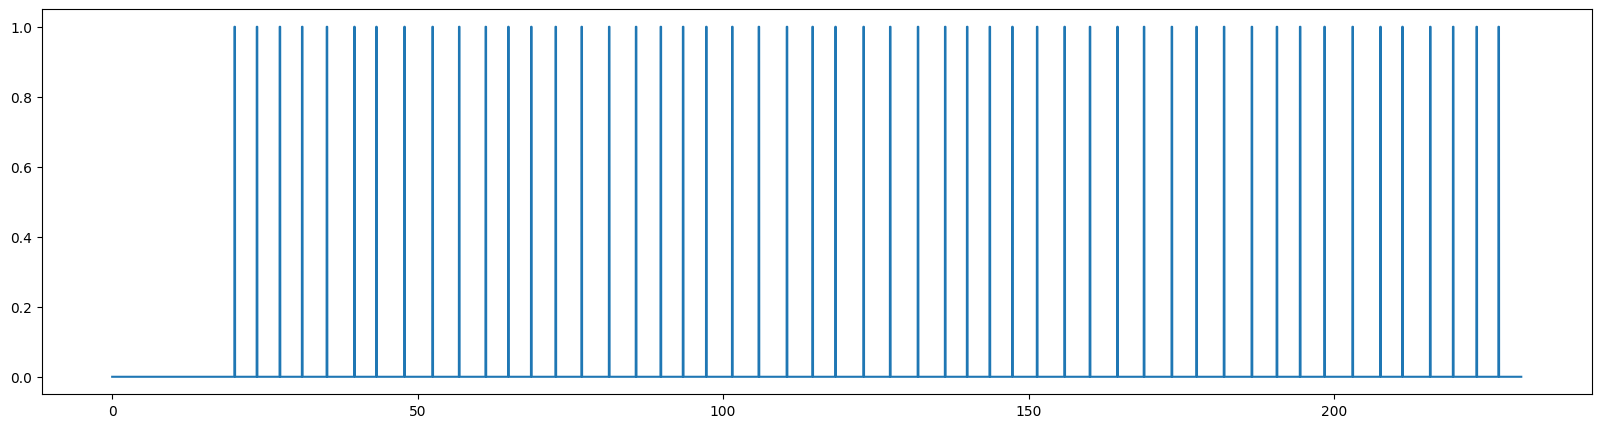

In [8]:

my_task = 'task1'

fig = plt.figure(figsize=(20,5))
plt.plot(grasp_cont_dict[my_task]['states'].time, grasp_cont_dict[my_task]['states'])

# PLOTTING STATE ARRAY TO INFORM THE STATE LABEL MAPPING

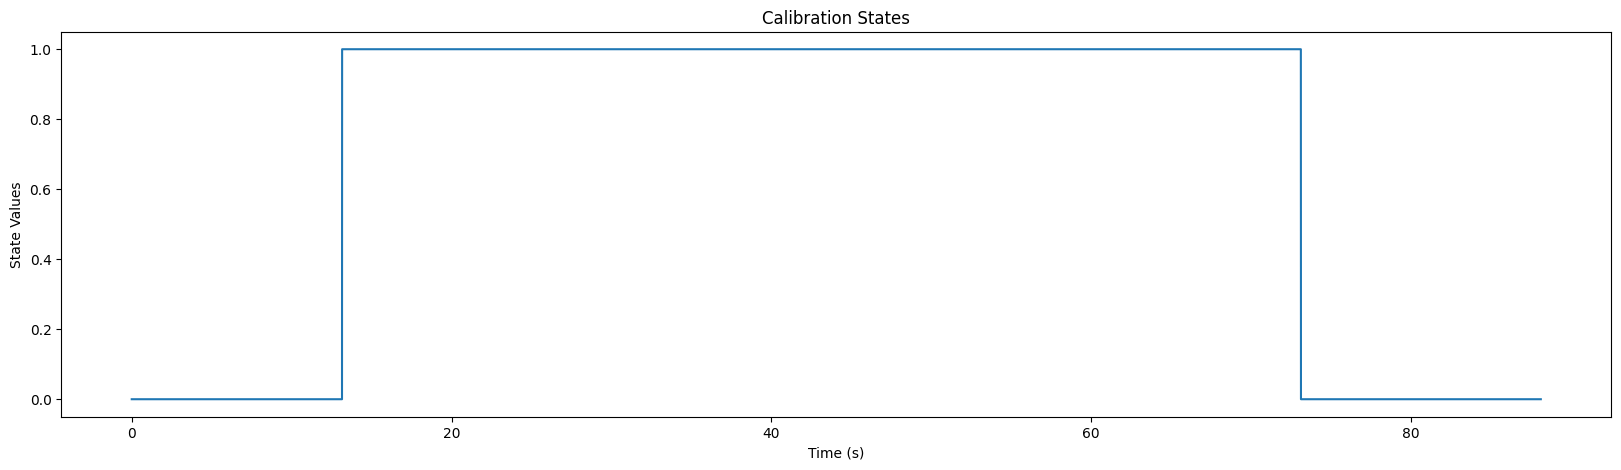

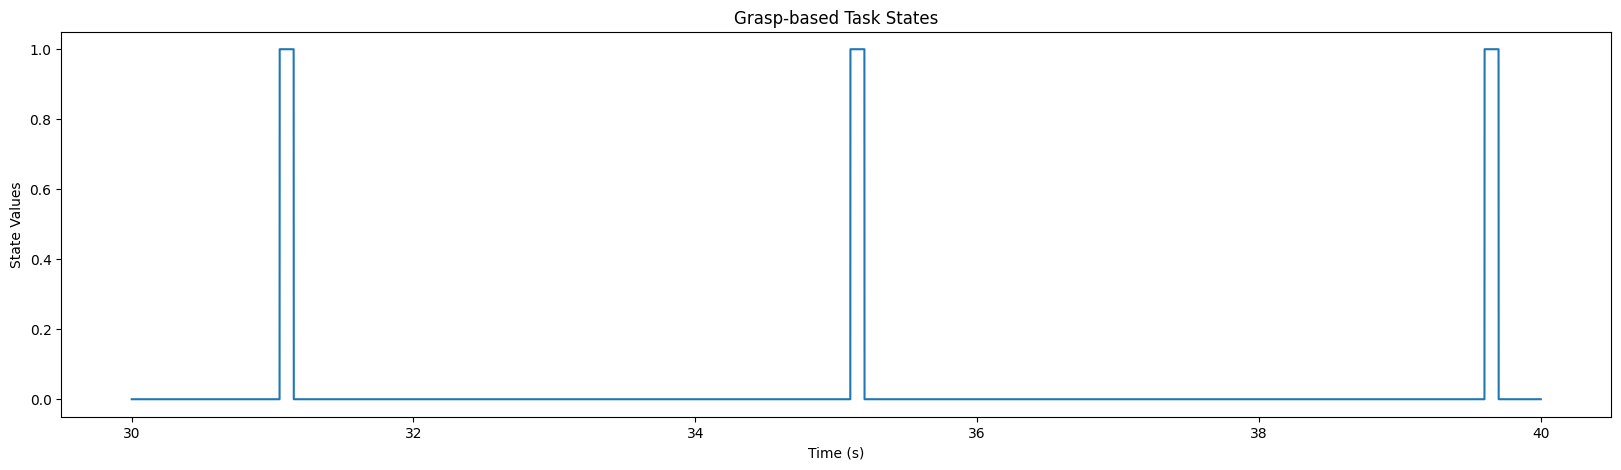

In [9]:
"""
DESCRIPTION:
PPlotting the stimuli of an experimenter-specified task such as to observe how many state values there are. This
will inform the state mapping in the next cell.
"""

# EXPERIMENTER INPUTS:
task_id = 'task1'

"""
INPUT VARIABLES:
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from the calibration tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the calibration
                 tasks. Time dimension is in units of seconds.
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the grasp-based
                 tasks. Time dimension is in units of seconds.
task_id:         [string (task ID)]; Task ID corresponding to the states that the experimenter wishes to see plotted.
"""

# COMPUTATION:

# Plotting the calibration and grasp states.
functions_model_training_visual_labeling.plotting_states(calib_cont_dict, grasp_cont_dict, task_id)


# CONVERTING THE STATE VALUES OF THE GRASP-BASED TASK TO STRINGS

In [10]:
"""
DESCRIPTION:
Converting the state values from integers to strings, as the string values are more descriptive.
"""
# EXPERIMENTER INPUTS:
# state_int2str = {0: 'state_OFF',
#                  1: 'state_ON'}

state_int2str = {0: 'state_OFF',
                 1: 'state_ON',
                 2: 'state_OFF'}

"""
INPUT VARIABLES:
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the grasp-based
                 tasks. Time dimension is in units of seconds.
state_int2str:   [dictionary (Key: int (state on/off value); Value: string (state_ON/state_OFF, respectively)]; Mapping
                 from the numerical values to the string values.

OUTPUT VARIABLES:
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
        signals: Same as input.
        states:  [xarray (1 x time samples) > strings ('state_ON'/'state_OFF')]; Array of states at each time sample for the
                 grasp-based tasks. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Converting the integer state values to strings.
grasp_cont_dict = functions_model_training_visual_labeling.string_state_maker(grasp_cont_dict, state_int2str)


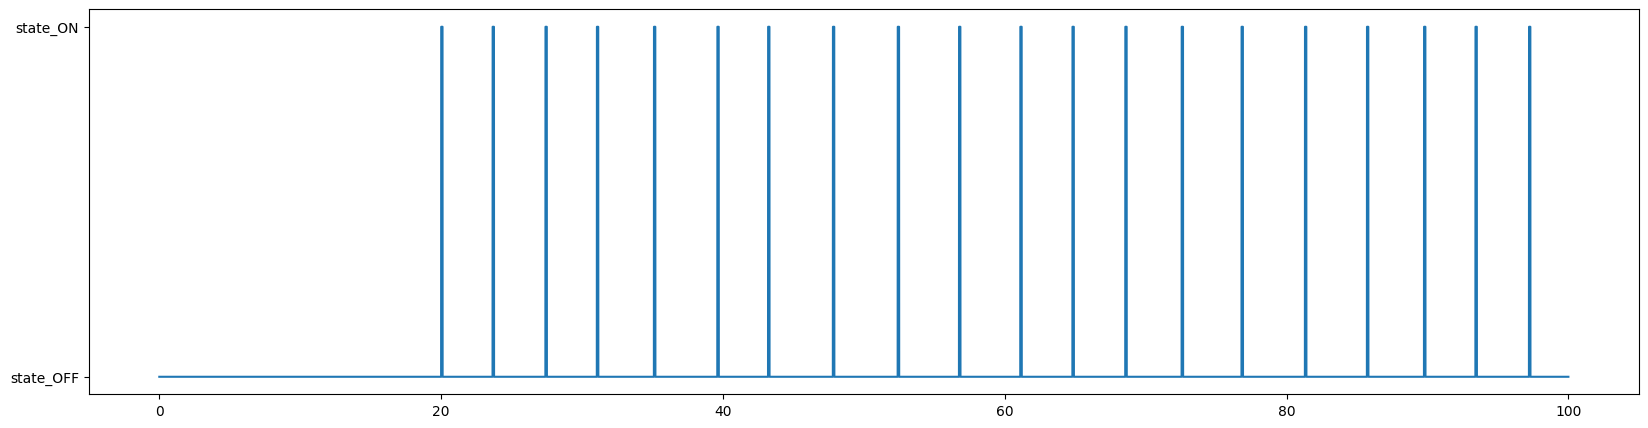

In [11]:

task_id   = 'task1'
idx_start = 0
idx_end   = 100000

fig = plt.figure(figsize=(20,5))
plt.plot(grasp_cont_dict[task_id]['states'][idx_start:idx_end].time, grasp_cont_dict[task_id]['states'][idx_start:idx_end])

# OPTIONAL POST-STIMULUS NEUTRAL LABELS

In [13]:
"""
DESCRIPTION:
This function allows the experimenter to assign 'neutral' labels to any time period after a state (cue or click) occurs. Note that this
function was written specifically for training decoders from real-time use (control clicks with speller), where two clicks may have 
occurred one immediately after the other. In this situation, the data from the second click should not be used to train a click model 
because of increased neural activity that may have not fallen to baseline since the first click occurred. In this situation, 'neutral' 
labels would overwrite all time points from the first click to some time period past the second click. For example, consider the
following:

state:               0         0         1         1         0         1         1         0         0         0         1        1        0
time sample:         0         1         2         3         4         5         6         7         8         9         10       11       12
original labels: state_OFF state_OFF state_ON  state_ON  state_OFF state_ON  state_ON  state_OFF state_OFF state_OFF state_ON state_ON state_OFF
modified labels: state_OFF state_OFF state_ON  state_ON  neutral   neutral   neutral   neutral   state_OFF state_OFF state_ON state_ON neutral

In the above example (sampling resolution not to scale), the first click occurred at samples 2 and 3, while the second click occurred
at samples 5 and 6. The second click occurred to soon after the first click. Therefore, after the end of the first click, the 'neutral'
label is applied for some samples, which wipes away the 'state_ON' labels from the second click. Therefore, those 'state_ON' labels will
not be used to train the model. The third click, occurring at samples 10 and 11, occurs after a longer period of time after the second
click, but the 'neutral' labels are still applied at the end of the third click.

The number of samples which will be replaced by 'neutral' corresponds to the experimenter-determined time, t_neutral_interval, which 
is in units of seconds.
"""

# EXPERIMENTER INPUT:
t_neutral_interval = 0 #3 # 3 5

"""
INPUT VARIABLES:
grasp_cont_dict:    [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals         [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                    voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:         [xarray (1 x time samples) > strings ('state_ON'/'state_OFF')]; Array of states at each time sample for the
                    grasp-based tasks. Time dimension is in units of seconds.
t_neutral_interval: [float (units: s)]; Amount of time after state offset that will be labeled as neutral.               

NECESSARY FUNCTIONS:
unique_value_index_finder

OUTPUT VARIABLES:
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Array of states at each time sample for the
                 grasp-based tasks. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Updating the state arrays with neutral periods.
grasp_cont_dict = functions_model_training_visual_labeling.post_state_neutral_labeling(grasp_cont_dict, t_neutral_interval)


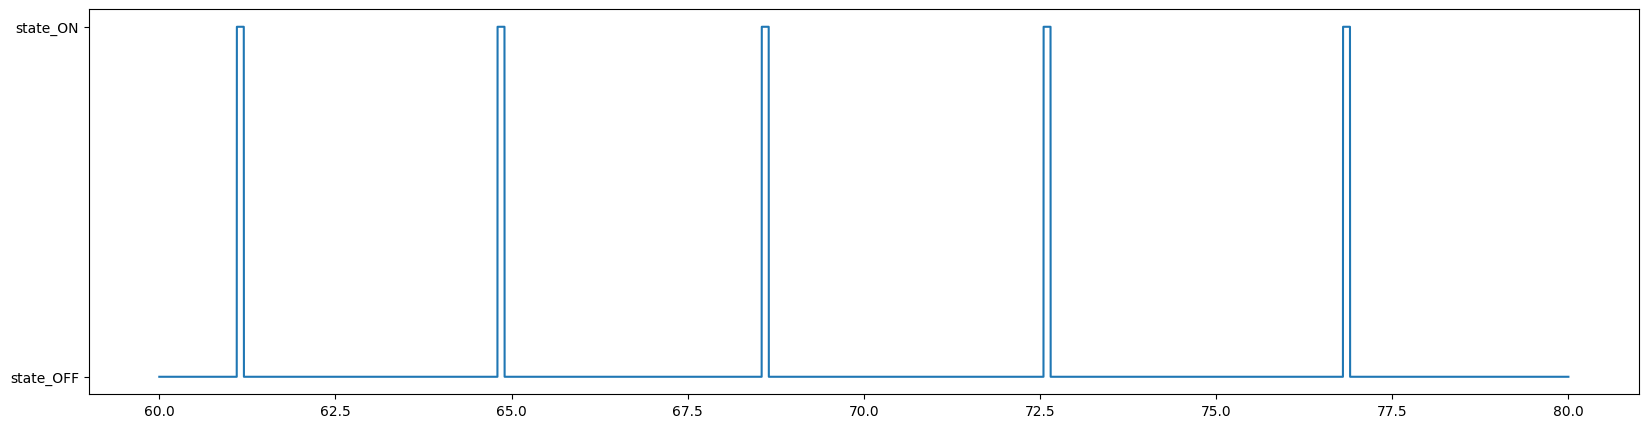

In [14]:

task_id   = 'task1'
idx_start = 60000
idx_end   = 80000

fig = plt.figure(figsize=(20,5))
plt.plot(grasp_cont_dict[task_id]['states'][idx_start:idx_end].time, grasp_cont_dict[task_id]['states'][idx_start:idx_end])

# EXTRACTING ONLY RELEVANT CALIBRATION SIGNALS

In [15]:
"""
DESCRIPTION:
Only the signals and stimuli where the stimulus equals the calibration stimulus value are extracted.

INPUT VARIABLES:
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from the calibration tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array of states at each time sample for the calibration
                 tasks. Time dimension is in units of seconds.

GLOBAL PARAMETERS (in functions_click_detector_final_model_training.py):
calib_state_val: [int]; The state value from where to extract the appropriate calibration data.

OUTPUT VARIABLES:
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of only continuous
                 voltage signals from only the relevant time samples for the calibration tasks. Time dimension is in
                 units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array if states from only the relevant time samples for
                 the calibration tasks. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Extracting only the relevant calibration signals.
calib_cont_dict = functions_model_training_visual_labeling.calib_signals_relevant(calib_cont_dict)


# CAR FILTERING

In [16]:
"""
DESCRIPTION:
The signals from the included channels will be extracted and referenced to their common average at each time
point (CAR filtering: subtracting the mean of all signals from each signal at each time point). The experimenter
may choose to CAR specific subset of channels or to CAR all the channels together. If the experimenter wishes to
CAR specific subsets of channels, each subset of channels should be written as a sublist, within a larger nested
list. For example: [[ch1, ch2, ch3],[ch8, ch10, ch13]].

INPUT VARIABLES:
car_tag:         [string]; What type of data is being CAR-ed.
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of only continuous
                 voltage signals from only the relevant time samples for the calibration tasks. Time dimension is in
                 units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array if states from only the relevant time samples for
                 the calibration tasks. Time dimension is in units of seconds.
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Array of states at each 
                 time sample for the grasp-based tasks. Time dimension is in units of seconds.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
car:        [bool (True/False)] Whether or not CAR filtering will be performed.
patient_id: [string]; Patient PYyyNnn ID or CCXX ID.

OUTPUT VARIABLES:
calib_raw_dict: Same as above, only the signals data may or may not be CAR filtered.
grasp_raw_dict: Same as above, only the signals data may or may not be CAR filtered.
"""

# COMPUTATION:

# CAR-filtering the signals, if the experimenter wishes.
calib_cont_dict = functions_model_training_visual_labeling.car_filter(calib_cont_dict, 'CALIBRATION')
grasp_cont_dict = functions_model_training_visual_labeling.car_filter(grasp_cont_dict, 'GRASP-BASED')



CALIBRATION

GRASP-BASED


# GENERATING SPECTROGRAMS

In [17]:
"""
DESCRIPTION:
Creating the spectrogram for each channel across all tasks. Also downsampling the states array to match the 
spectrogram resolution.

INPUT VARIABLES:
calib_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of only continuous
                 voltage signals from only the relevant time samples for the calibration tasks. Time dimension is in
                 units of seconds.
    states:      [xarray (1 x time samples) > ints (0 or 1)]; Array if states from only the relevant time samples for
                 the calibration tasks. Time dimension is in units of seconds.
grasp_cont_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    signals:     [xarray (channels x time samples (units: s) > floats (units: microvolts)]; Array of continuous
                 voltage signals from grasp-based tasks. Time dimension is in units of seconds.
    states:      [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Array of states at each 
                 time sample for the grasp-based tasks. Time dimension is in units of seconds.
    
GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
sxx_shift:  [int (units: ms)]; Length of time by which sliding window (sxx_window) shifts along the time domain.
sxx_window: [int (units: ms)]; Time length of the window that computes the frequency power.

OUTPUT VARIABLES:
calib_sxx_dict:  [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                 continuous voltage signals from calibration. Time dimension is in units of seconds.
    sxx_states:  [xarray (1 x time samples) > ints (0 or 1)]; States array downsampled to match time resolution of 
                 the signal spectral power. Time dimension is in units of seconds.
grasp_sxx_dict:  [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                 continuous voltage signals from the grasp-based task. Time dimension is in units of seconds.
    sxx_states:  [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; States array downsampled
                 to match time resolution of the signal spectral power. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Computing the spectral power of the signals and downsampling the stimulus array accordingly.
calib_sxx_dict = functions_model_training_visual_labeling.spectrogram_generator(calib_cont_dict, 'CALIBRATION') 
grasp_sxx_dict = functions_model_training_visual_labeling.spectrogram_generator(grasp_cont_dict, 'GRASP-BASED') 



CALIBRATION
CALIBRATION   task0
CALIBRATION   task1
CALIBRATION   task2
CALIBRATION   task3
CALIBRATION   task4
CALIBRATION   task5

GRASP-BASED
GRASP-BASED   task0
GRASP-BASED   task1
GRASP-BASED   task2
GRASP-BASED   task3
GRASP-BASED   task4
GRASP-BASED   task5


# STANDARDIZING THE SIGNALS TO THE CALIBRATION PERIOD

In [18]:
"""
DESCRIPTION:
For each channel at each frequency, standardizing the spectral power to the statistics of the calibration period. 

INPUT VARIABLES:
calib_sxx_dict:  [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                 continuous voltage signals from calibration. Time dimension is in units of seconds.
    sxx_states:  [xarray (1 x time samples) > ints (0 or 1)]; States array downsampled to match time resolution of 
                 the signal spectral power. Time dimension is in units of seconds.
grasp_sxx_dict:  [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                 continuous voltage signals from the grasp-based task. Time dimension is in units of seconds.
    sxx_states:  [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; States array downsampled
                 to match time resolution of the signal spectral power. Time dimension is in units of seconds.

OUTPUT VARIABLES:
grasp_sxx_dict:    [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals:   Same as input.
    sxx_signals_z: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Standardized Spectral
                   power of the continuous voltage signals from grasp-based task.
    sxx_states:    Same as input.
"""

# COMPUTATION:

# Standardizing the spectral power to the calibration period.
grasp_sxx_dict = functions_model_training_visual_labeling.standardize_to_calibration(calib_sxx_dict, grasp_sxx_dict) 


STANDARDIZING GRASP TASK:  task0
STANDARDIZING GRASP TASK:  task1
STANDARDIZING GRASP TASK:  task2
STANDARDIZING GRASP TASK:  task3
STANDARDIZING GRASP TASK:  task4
STANDARDIZING GRASP TASK:  task5


# GENERATING BAND POWER

In [19]:
"""
DESCRIPTION:
Given the experimenter-specified minimum and maximum frequencies, the band power from the unstandardized and calibration-
standardized spectrograms are computed.

INPUT VARIABLES:
grasp_sxx_dict:    [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals:   [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                   continuous voltage signals from the grasp-based task. Time dimension is in units of seconds.
    sxx_signals_z: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Standardized Spectral
                   power of the continuous voltage signals from grasp-based task.
    sxx_states:    [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; States array downsampled
                   to match time resolution of the signal spectral power. Time dimension is in units of seconds.
                   
GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
f_power_max: [list > int (units: Hz)]; For each frequency band, maximum power band frequency.
f_power_min: [list > int (units: Hz)]; For each frequency band, minimum power band frequency.
    
OUTPUT VARIABLES:
grasp_bandpower_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:        [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                      the band power is computed for each channel across every time point.
    sxx_power_z:      [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                      calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Computing the band power for the frequency bands. 
grasp_bandpower_dict = functions_model_training_visual_labeling.power_generator(grasp_sxx_dict) 


# EXTRACTING PER-TRIAL SPECTRAL INFORMATION BETWEEN PRE- AND POST-STATE ON TIMES

In [20]:
"""
DESCRIPTION:
A trial onset is defined from a state change from state OFF to state ON. The states are specified in the
grasp_state_dict and calib_state_dict. The per-trial spectrograms and band powers that are aligned to these state
onsets are computed. Bounded by the experimenter-input pre- and post-state onset times.
"""

# EXPERIMENTER INPUTS:
t_pre_on_state  = -1 # -1  # -1.5
t_post_on_state = 2.5 # 2.5 # 1.5

"""
INPUT VARIABLES:
grasp_bandpower_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:        [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                      the band power is computed for each channel across every time point.
    sxx_power_z:      [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                      calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
grasp_sxx_dict:       [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals:      [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                      continuous voltage signals from the grasp-based task. Time dimension is in units of seconds.
    sxx_signals_z:    [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Standardized Spectral
                      power of the continuous voltage signals from grasp-based task.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; States array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
t_post_on_state:      [float (units: s)]; The amount of time after the cue for visualizing the trial-averaged information.
t_pre_on_state:       [float (units: s)]; The amount of time before the cue for visualizing the trial-averaged information.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
sxx_shift: [int (units: ms)]; Length of time by which sliding window (sxx_window) shifts along the time domain.

OUTPUT VARIABLES:
grasp_bandpower_dict:  [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:         Same as input.
    sxx_power_z:       Same as input.
    sxx_states:        Same as input.        
    power_trials_z:    [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                       information for each trial. Time dimension is in units of seconds.
grasp_sxx_dict:        [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
        sxx_signals:   Same as input.
        sxx_signals_z: Same as input.
        sxx_states:    Same as input.        
        sxx_trials_z:  [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                       information for each trial. Time dimension is in units of seconds.
"""

# COMPUTATION:

# Computing the per-trial spectrograms and band power.
grasp_sxx_dict       = functions_model_training_visual_labeling.spectrogram_info_per_trial(grasp_sxx_dict, t_post_on_state, t_pre_on_state)
grasp_bandpower_dict = functions_model_training_visual_labeling.power_info_per_trial(grasp_bandpower_dict, t_post_on_state, t_pre_on_state)


# TRIAL-AVERAGING SPECTROGRAMS

In [21]:
"""
DESCRIPTION:
Computing the trial averaged spectrogram.

INPUT VARIABLES:
grasp_sxx_dict:    [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_signals:   [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Spectral power of the
                   continuous voltage signals from the grasp-based task. Time dimension is in units of seconds.
    sxx_signals_z: [xarray (channels x frequency bins x time samples) > floats (units: V^2/Hz)]; Standardized Spectral
                   power of the continuous voltage signals from grasp-based task.
    sxx_states:    [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; States array downsampled
                   to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    sxx_trials_z:  [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                   information for each trial. Time dimension is in units of seconds.

NECESSARY FUNCTIONS:
index_advancer

OUTPUT VARIABLES:
sxx_trial_mean: [xarray (channels x frequency x time samples) > floats]; Trial-averaged standardized segmented spectral 
                power.
"""

# COMPUTATION:

# Computing the spectrogram trial mean.
sxx_trial_mean = functions_model_training_visual_labeling.spectrogram_trial_averaging(grasp_sxx_dict)


# POWER TRIAL RASTERS

In [22]:
"""
DESCRIPTION:
Concatenating power trial rasters across all tasks.

INPUT VARIABLES:
grasp_bandpower_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:        [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                      the band power is computed for each channel across every time point.
    sxx_power_z:      [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                      calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    power_trials_z:   [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                      information for each trial. Time dimension is in units of seconds.

NECESSARY FUNCTIONS:
index_advancers

OUTPUT VARIABLES:
ptr_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral information
                for each trial (across all tasks). Time dimension is in units of seconds.
"""

# COMPUTATION:

# Concatenating the power trial rasters across all tasks.
ptr_all_trials = functions_model_training_visual_labeling.creating_power_trial_rasters(grasp_bandpower_dict)


# PLOTTING TRIAL-AVERAGED SPECTROGRAMS

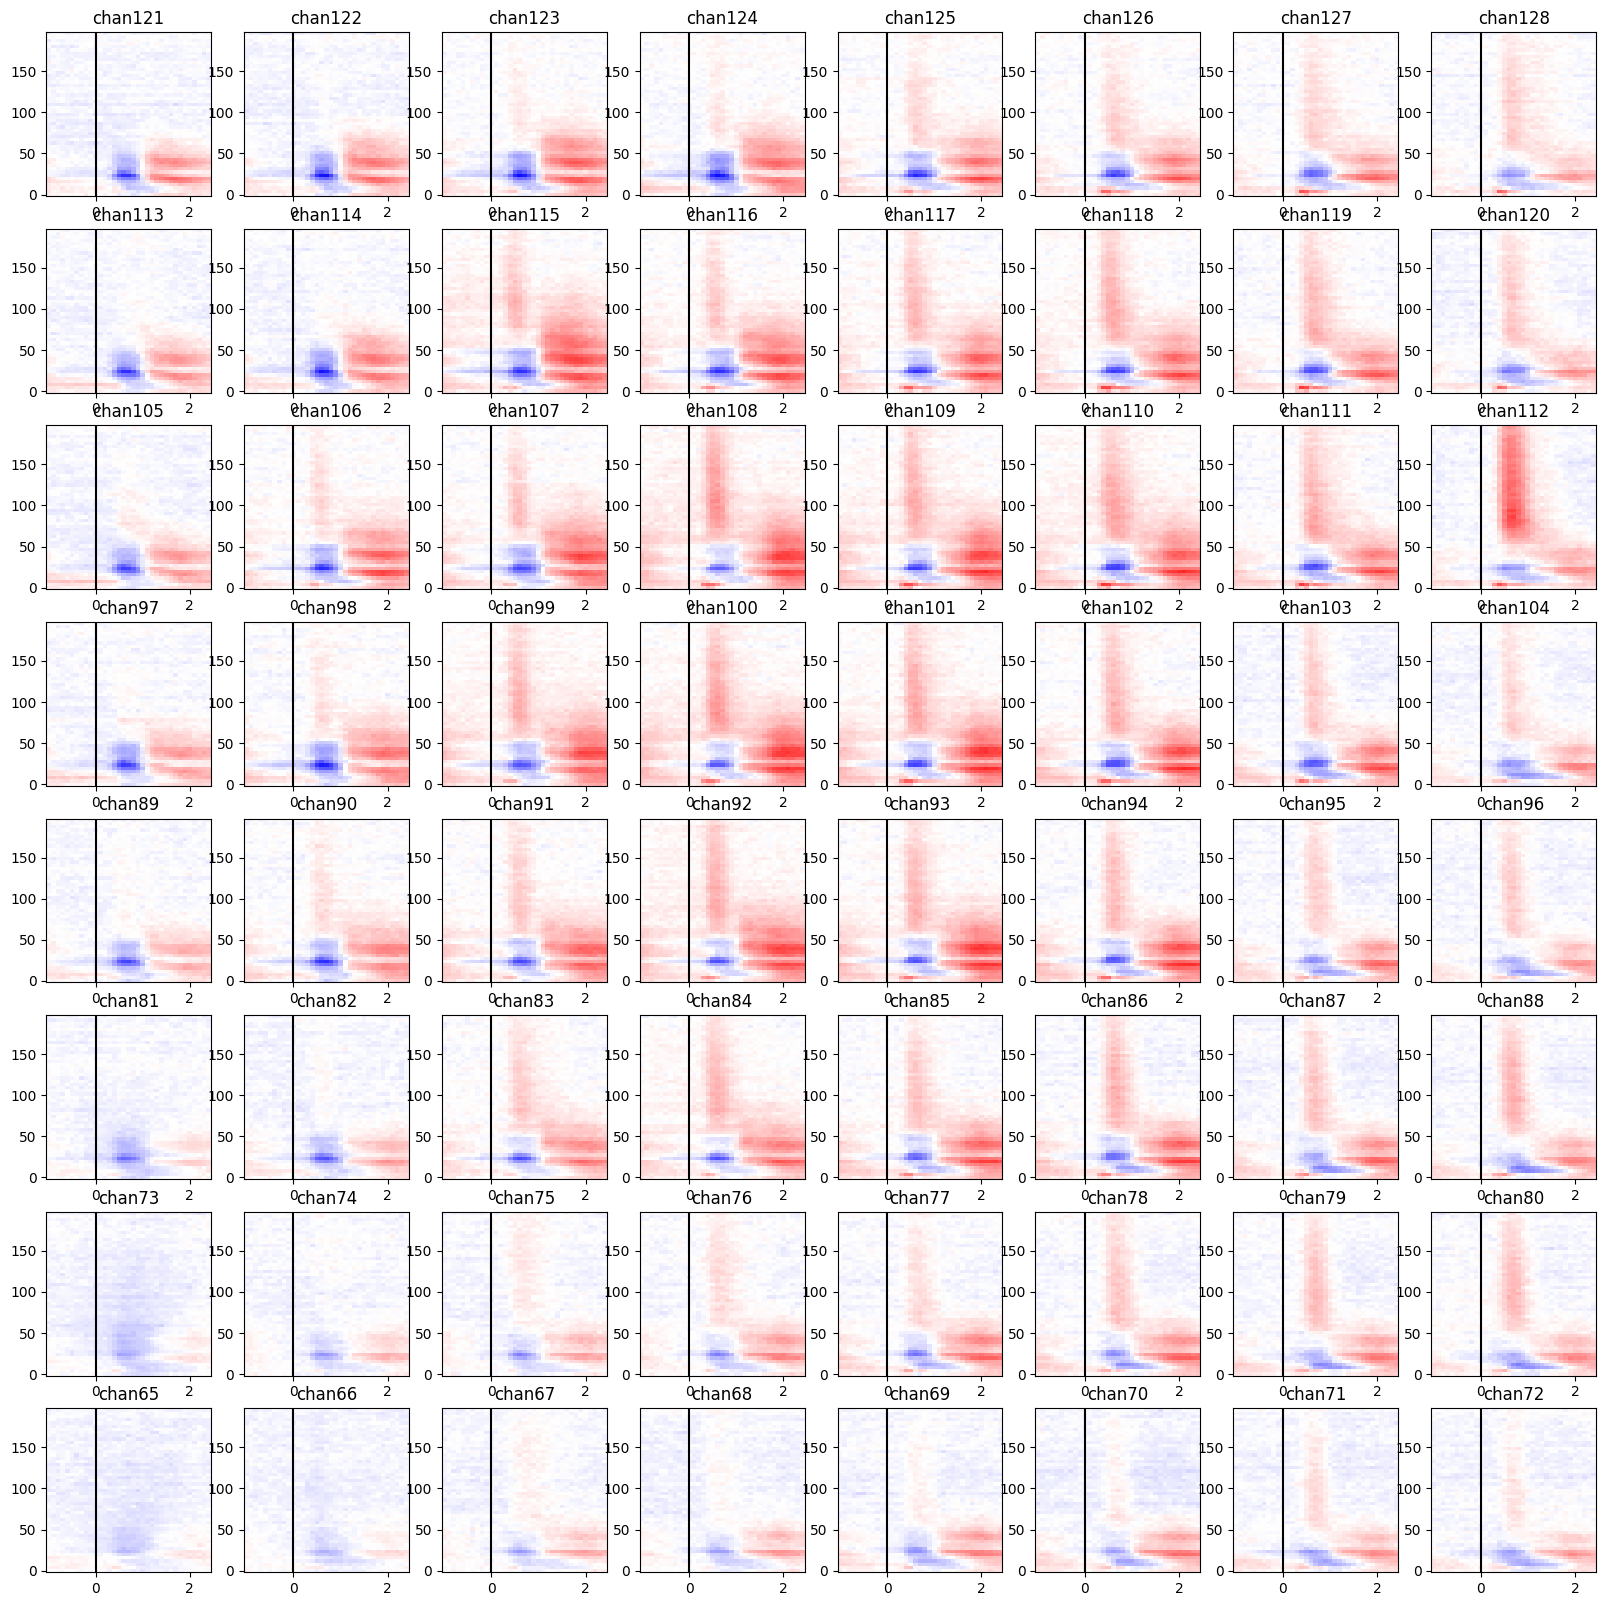

In [23]:
"""
DESCRIPTION:
The experimenter may input the channel type (upperlimb or speech) such as to display the trial-averaged spectrograms
for that set of channels. The experimenter may also wish to input the frequency bounds within which these averaged 
spectrograms will be viewed.
"""
# EXPERIMENTER INPUTS:
f_min               = 0 
f_max               = 200 
fig_height          = 20
fig_width           = 20
upperlimb_or_speech = 'upperlimb'
v_min               = -2   
v_max               = 2    

"""
INPUT VARIABLES:
chs_exclude:         [list > strings]; The list of channels to be excluded in further analysis and whose spectral
                     information will not be shown.
f_max:               [int]; The maximum frequency to be displayed in the averaged spectral plots. Leave as [] for
                     maximum frequency.
f_min:               [int]; The minimum frequency to be displayed in the averaged spectral plots. Leave as [] for
                     minimum frequency.
fig_height:          [int]; The height of the subplot figure showing the trial averaged spectrograms.
fig_width:           [int]; The width of the subplot figure showing the trial averaged spectrograms.
sxx_trial_mean:      [xarray (channels x frequency x time samples) > floats]; Trial-averaged standardized segmented
                     spectral power.
upperlimb_or_speech: [string ('upperlimb'/'speech')]; Whether to plot the spectrograms of the upper-limb or speech grid.    
v_max:               [int]; Maximum value for colorplot.
v_min:               [int]; Minimum value for colorplot.
"""

# COMPUTATION:

# Plotting the trial-averaged spectrograms.
functions_model_training_visual_labeling.spectrogram_plotting(chs_exclude, f_max, f_min, fig_height, fig_width,\
                                                              sxx_trial_mean, upperlimb_or_speech, v_max, v_min)


# PLOTTING POWER TRIAL RASTERS

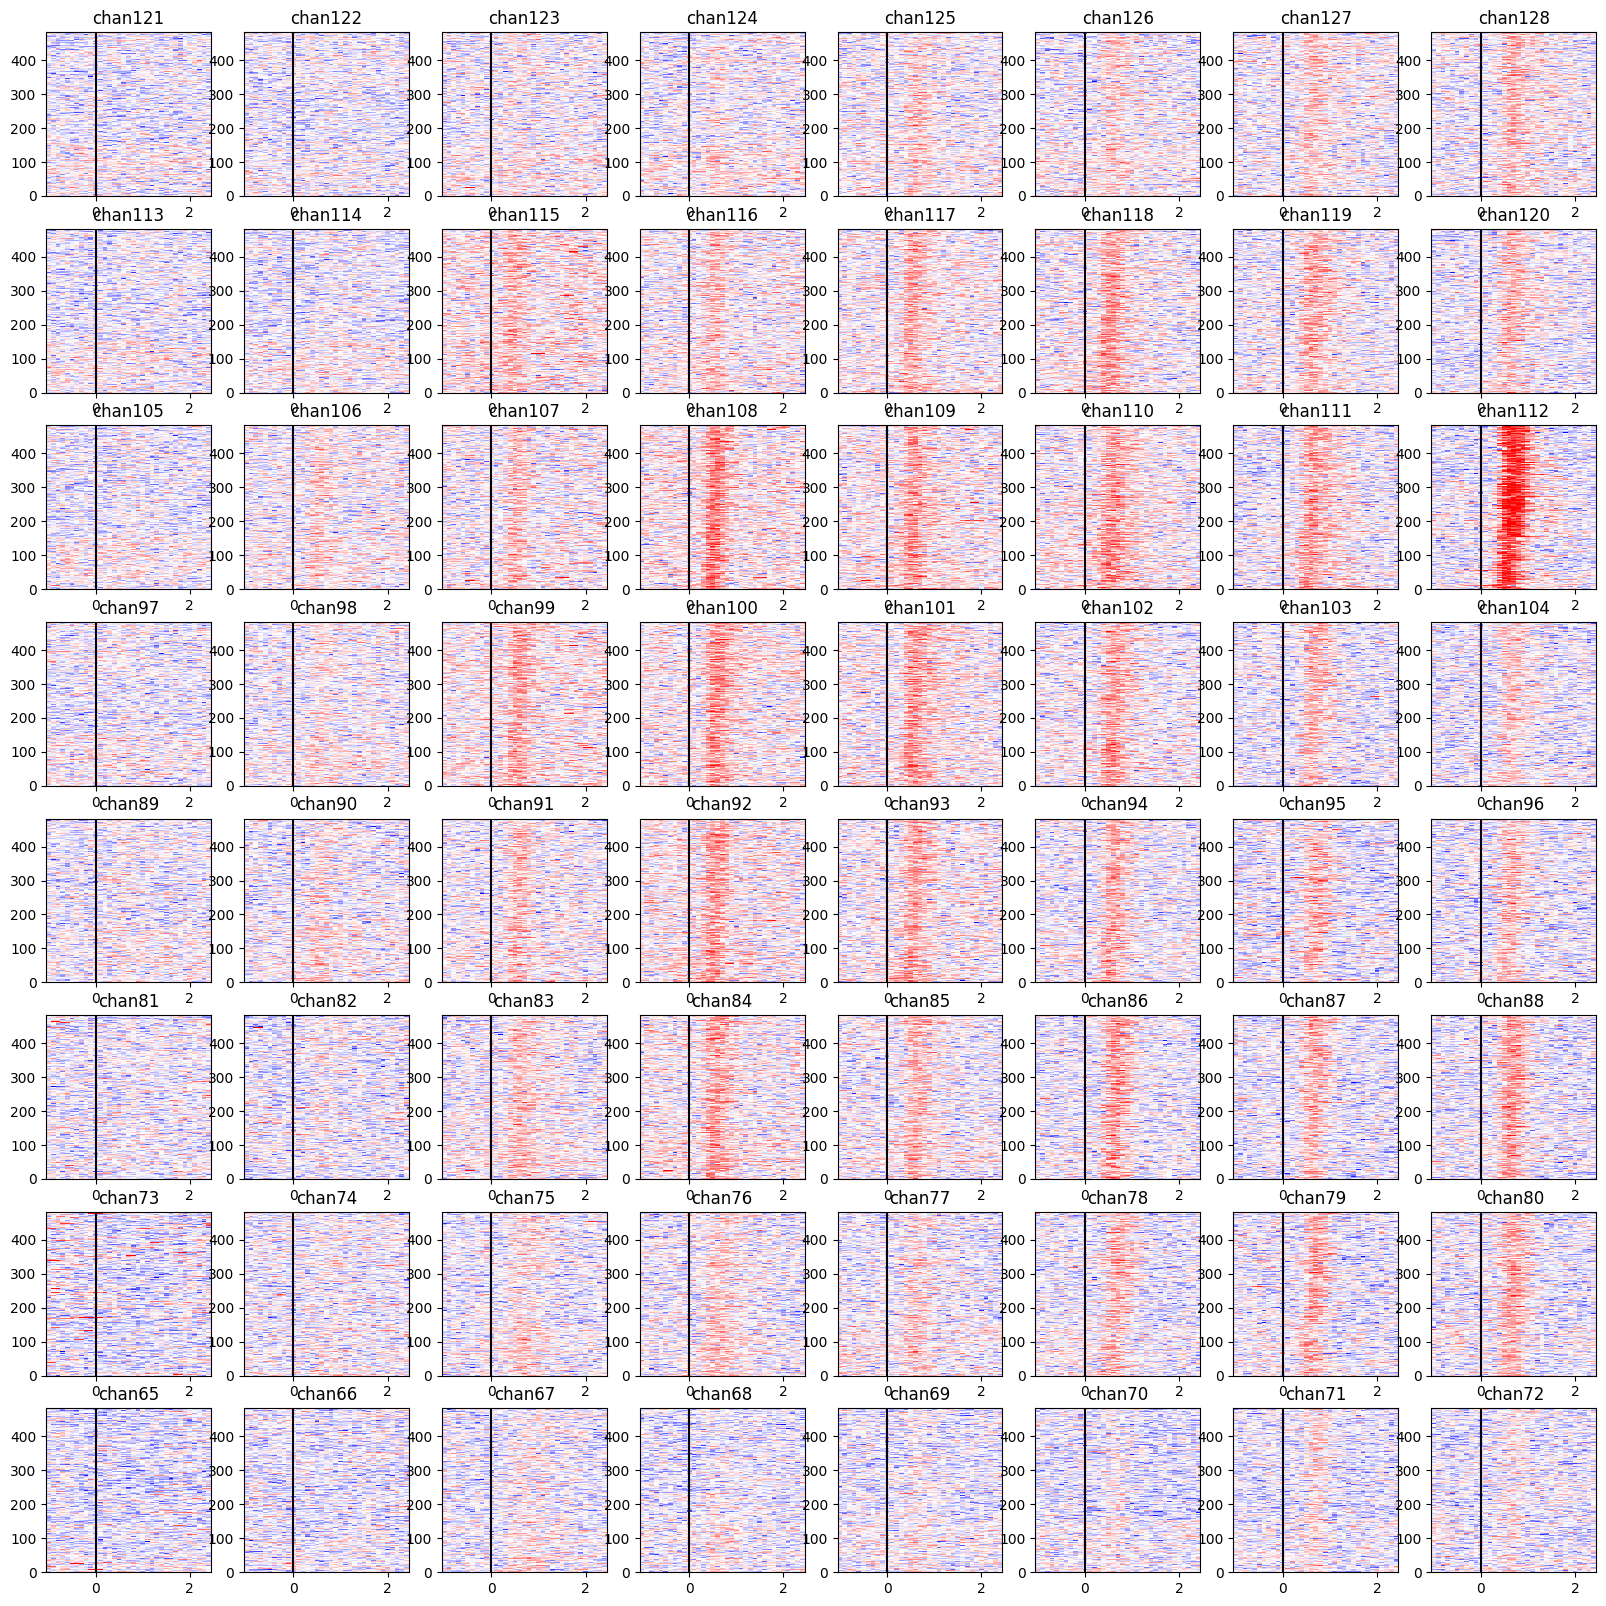

In [24]:
"""
DESCRIPTION:
Plotting the power trial rasters across all tasks.
"""
# EXPERIMENTER INPUTS:
fig_height          = 20
fig_width           = 20
powerband_id        = 'powerband0'
upperlimb_or_speech = 'upperlimb'
v_max               = 20
v_min               = -20

"""
INPUT VARIABLES:
chs_exclude:         [list > strings]; The list of channels to be excluded in further analysis and whose spectral
                     information will not be shown.
fig_height:          [int]; The height of the subplot figure showing the trial averaged spectrograms.
fig_width:           [int]; The width of the subplot figure showing the trial averaged spectrograms.
powerband_id:        [string (powerband#)]; The index of the powerband.              
ptr_all_trials:      [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                     information for each trial (across all tasks). Time dimension is in units of seconds.
upperlimb_or_speech: [string ('upperlimb'/'speech')]; Whether to plot the spectrograms of the upper-limb or speech grid. 
v_max:               [int]; Maximum value for colorplot.
v_min:               [int]; Minimum value for colorplot.
"""

# COMPUTATION:

# Plotting the power trial rasters across all tasks.
functions_model_training_visual_labeling.power_trial_raster_plotting(chs_exclude, fig_height, fig_width, powerband_id,\
                                                                     ptr_all_trials, upperlimb_or_speech, v_max, v_min)


In [25]:
ptr_all_trials.shape

(483, 128, 1, 35)

# CREATING AFFINE WARP MODEL

In [26]:
"""
DESCRIPTION:
Each trial of the power trial rasters will be shifted in time be some trial-specific value such that the inter-trial
correlation increases. This shifting will occur because of the natural variability in delay between the state ON onset
and onset of neural activity. For example, this variability may arise from the natural variation in the participant's
reaction delay when seeing a cue to make an attempted grasp.

An affine warp (aw) model (see https://github.com/ahwillia/affinewarp.git) is created to compute these shifts for each
trial. The aw model is trained on multiple channels (qualitatively selected) and on on power band from these channels.
The experimenter must also specify the time bounds within the power trial rasters by which this model will be trained.
"""

# EXPERIMENTER INPUTS:
chs_alignment = ["chan86", "chan88", "chan94", "chan101", "chan102", "chan108", "chan109", "chan110", "chan112"]
aw_powerband  = 'powerband0'
t_aw_start    = 0 #-1 #0# -1.25 # -1 # For Speller tasks. Use -1.25
t_aw_end      = 1.5 # 2 #0.75# 1          # For Speller tasks. Use 0.50 (using only 7 votes). 0.75 (with 4 votes include)

"""
INPUT VARIABLES:
aw_powerband:         [string ('powerbandX')]; Name of the powerband that will be used for aligning the power trial rasters.
                      X is an integer (0, 1, 2,...).
chs_alignment:        [list > strings]; The list of channels which will be used for affine warp. Leave as [] if all
                      channels will be used.
grasp_bandpower_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:        [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                      the band power is computed for each channel across every time point.
    sxx_power_z:      [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                      calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    power_trials_z:   [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                      information for each trial. Time dimension is in units of seconds.
ptr_all_trials:       [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral information
                      for each trial (across all tasks). Time dimension is in units of seconds.
t_aw_end:             [float (units: s)]; The ending time boundary for the HG onset period on which AW will be applied.
t_aw_start:           [float (units: s)]; The starting time boundary for the HG onset period on which AW will be applied.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
aw_model_type: [string ('shift'/'piecewise')]; The type of affine warp transformation the experimenter wishes to perform. 
               Leave empty [] if no AW-alignment will occur.

OUTPUT VARIABLES:
aw_model:                  [Affinewarp model]; Created using all trials.
aw_shifts:                 [dictionary (Key: string (Task ID); Value: dictionary (Key/Value pairs below)];
    N (where N is an int): [int]; AW shift for the Nth trial in units of samples.
"""

# COMPUTATION:

# Fitting the affine warp model.
aw_model, aw_shifts = functions_model_training_visual_labeling.aw_model_building(aw_powerband, chs_alignment, grasp_bandpower_dict,\
                                                                                 ptr_all_trials, t_aw_end, t_aw_start)


Loss: 19.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.32it/s]


# ALIGN POWER TRIAL RASTERS

In [27]:
"""
DESCRIPTION:
Aligning the power trial rasters (across all channels and powerbands) according to the affine warp model.

INPUT VARIABLES:
aw_model:       [Affinewarp model]; Created using all trials.
ptr_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral information
                for each trial (across all tasks). Time dimension is in units of seconds.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
aw_model_type: [string ('shift'/'piecewise')]; The type of affine warp transformation the experimenter wishes to perform. 
               Leave empty [] if no AW-alignment will occur.

OUTPUT VARIABLES:
ptr_aligned_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                        information for each aligned trial (across all tasks). Time dimension is in units of seconds.
"""

# COMPUTATION:

# Aligning the power trial rasters.
ptr_aligned_all_trials = functions_model_training_visual_labeling.aligning_power_trial_rasters(aw_model, ptr_all_trials)


# PLOTTING ALIGNED POWER TRIAL RASTERS

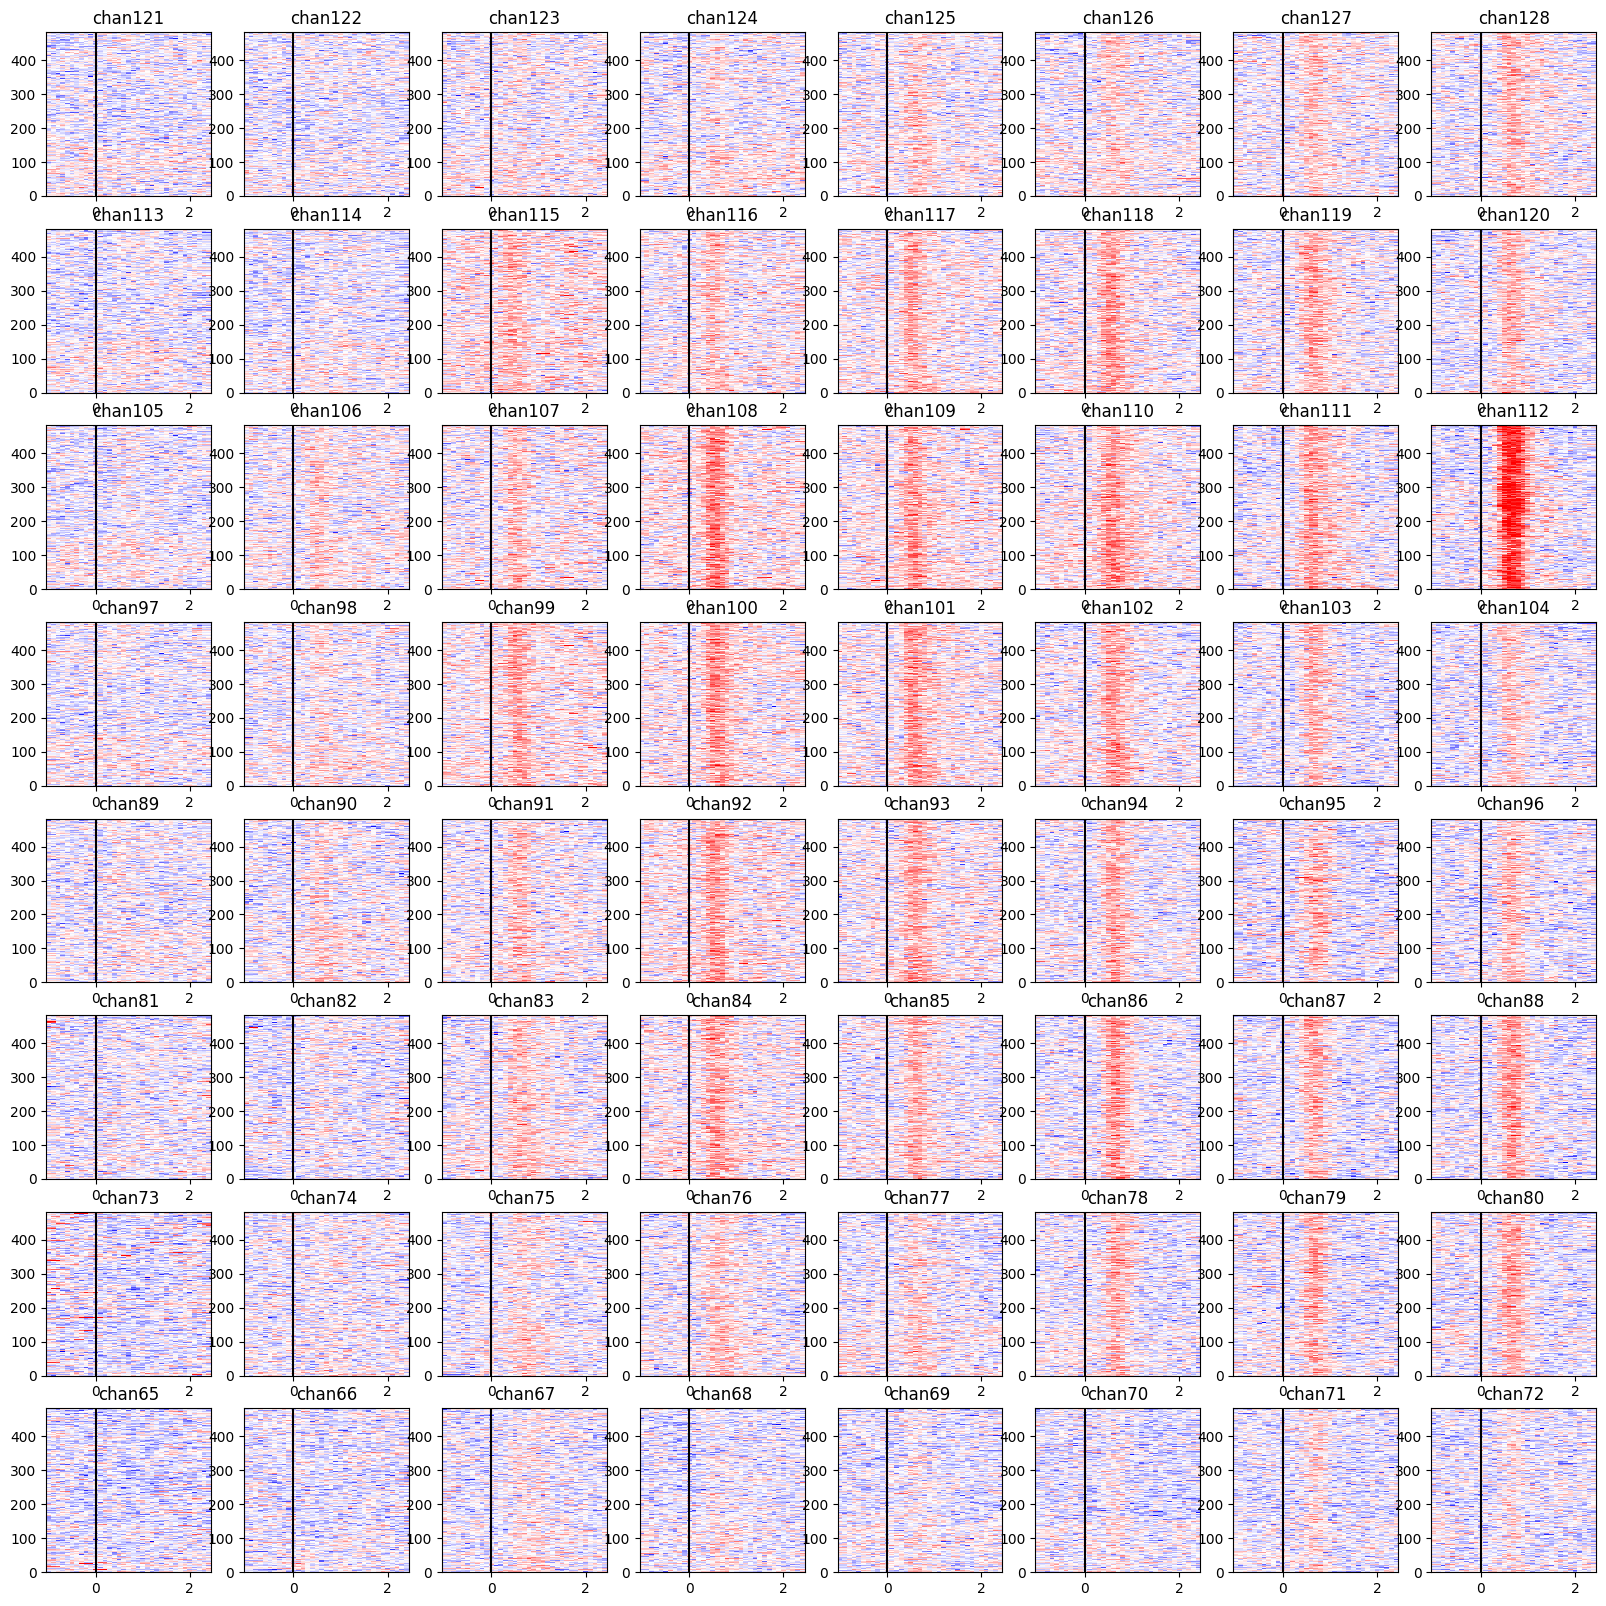

In [28]:
"""
DESCRIPTION:
Plotting the aligned power trial rasters across all tasks.
"""
# EXPERIMENTER INPUTS:
fig_height   = 20
fig_width    = 20
powerband_id = 'powerband0'
v_max        = 20
v_min        = -20

"""
INPUT VARIABLES:
chs_exclude:            [list > strings]; The list of channels to be excluded in further analysis and whose spectral
                        information will not be shown.
fig_height:             [int]; The height of the subplot figure showing the trial averaged spectrograms.
fig_width:              [int]; The width of the subplot figure showing the trial averaged spectrograms.
powerband_id:           [string (powerband#)]; The index of the powerband.               
ptr_aligned_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                        information for each aligned trial (across all tasks). Time dimension is in units of seconds.
upperlimb_or_speech:    [string ('upperlimb'/'speech')]; Whether to plot the spectrograms of the upper-limb or speech grid. 
v_max:                  [int]; Maximum value for colorplot.
v_min:                  [int]; Minimum value for colorplot.
"""

# COMPUTATION:

# Plotting the power trial rasters across all tasks.
functions_model_training_visual_labeling.power_trial_raster_plotting(chs_exclude, fig_height, fig_width, powerband_id,
                                                                     ptr_aligned_all_trials, upperlimb_or_speech, v_max, v_min)


# COMPARE INTER-TRIAL CORRELATION BEFORE AND AFTER ALIGNMENT

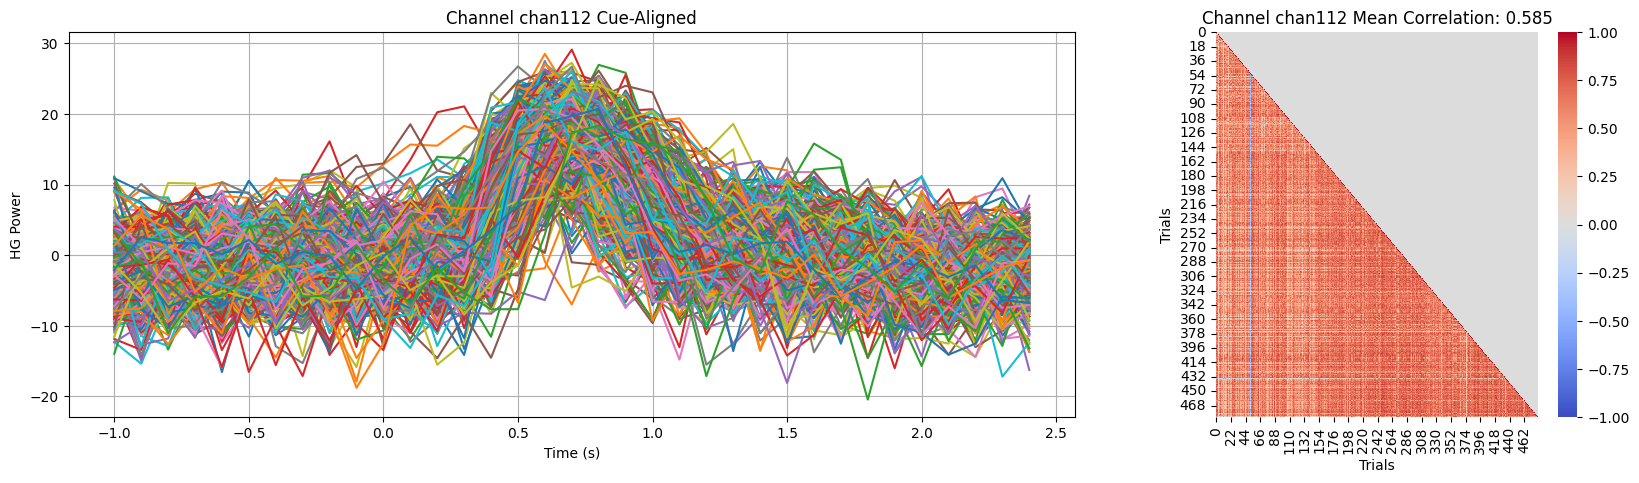

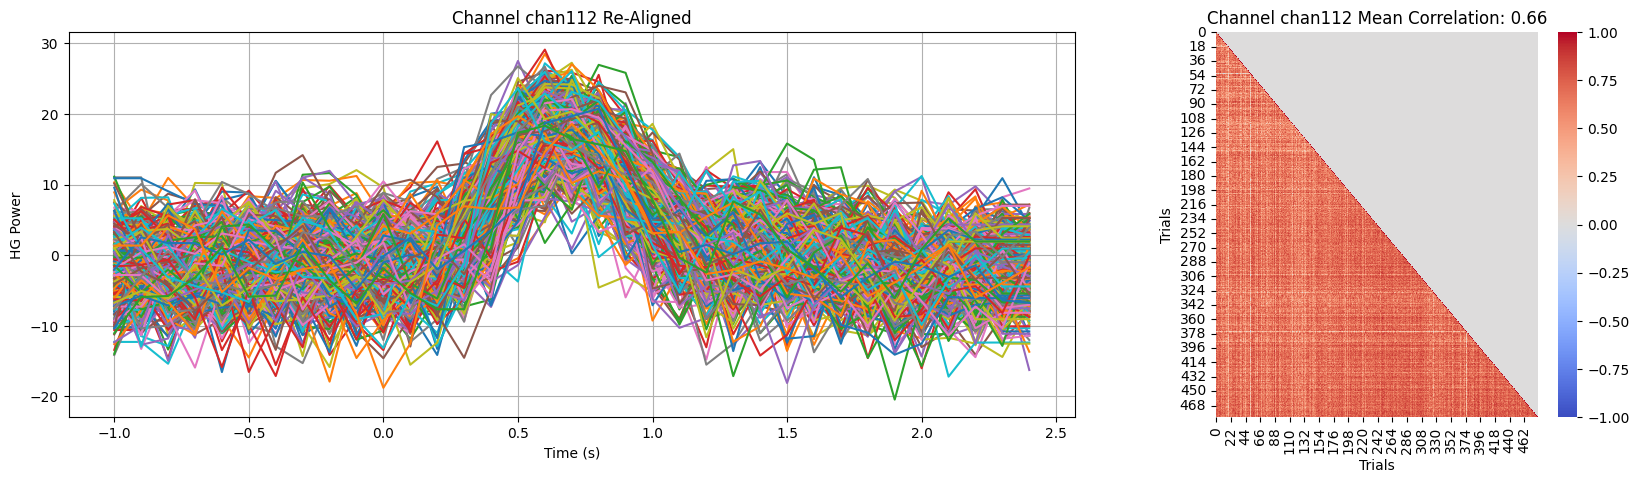

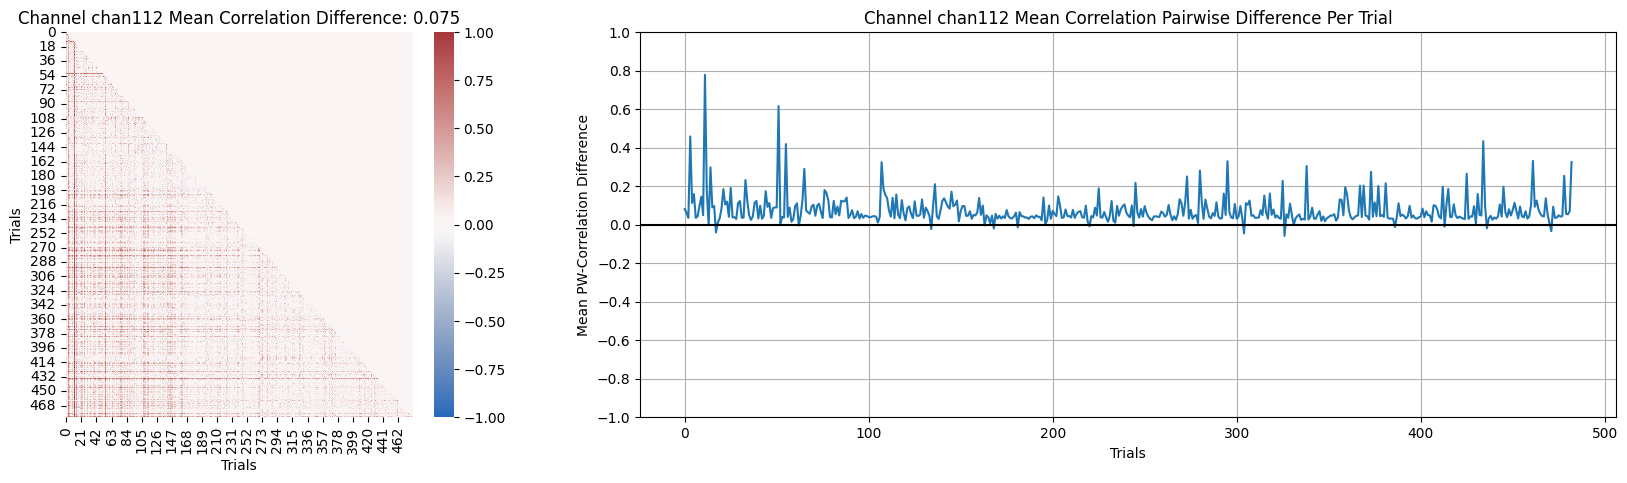

In [29]:
"""
DESCRIPTION:
After affine-warping the power trial rasters, the inter-trial correlations are compared to the power-trial rasters from
before alignment.
"""

# EXPERIMENTER INPUTS:
powerband_id = 'powerband0'
t_corr_start = -1 #-1 # -1.25     # -0.5 # -1 # For Speller tasks. Use -1.25
t_corr_end   = 2 #2 # 0.75   # 1.5 # 1 # For Speller tasks. Use 0.75
view_channel = 'chan112' 

"""
INPUT VARIABLES:
powerband_id:           [string]; The powerband whose power trial rasters the experimenter wishes to compare.
ptr_all_trials:         [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                        information for each trial (across all tasks). Time dimension is in units of seconds.
ptr_aligned_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                        information for each aligned trial (across all tasks). Time dimension is in units of seconds.
t_corr_end:             [float]; The ending time bound of the trials between which to take the pair-wise correlations.
t_corr_start:           [float]; The starting time bound of the trials between which to take the pair-wise correlations.
view_channel:           [string]; The experimenter-specified channel whose aligned and unaligned trials will be 
                        visualized.
"""

# COMPUTATION:

# Vizualizing the changes in correlation.
functions_model_training_visual_labeling.visualizing_affinewarp_adjustment(powerband_id, ptr_all_trials, ptr_aligned_all_trials,\
                                                                           t_corr_end, t_corr_start, view_channel)


# PLOTTING AVERAGE AFFINE WARPED TRACE FOR EACH WARPING CHANNEL

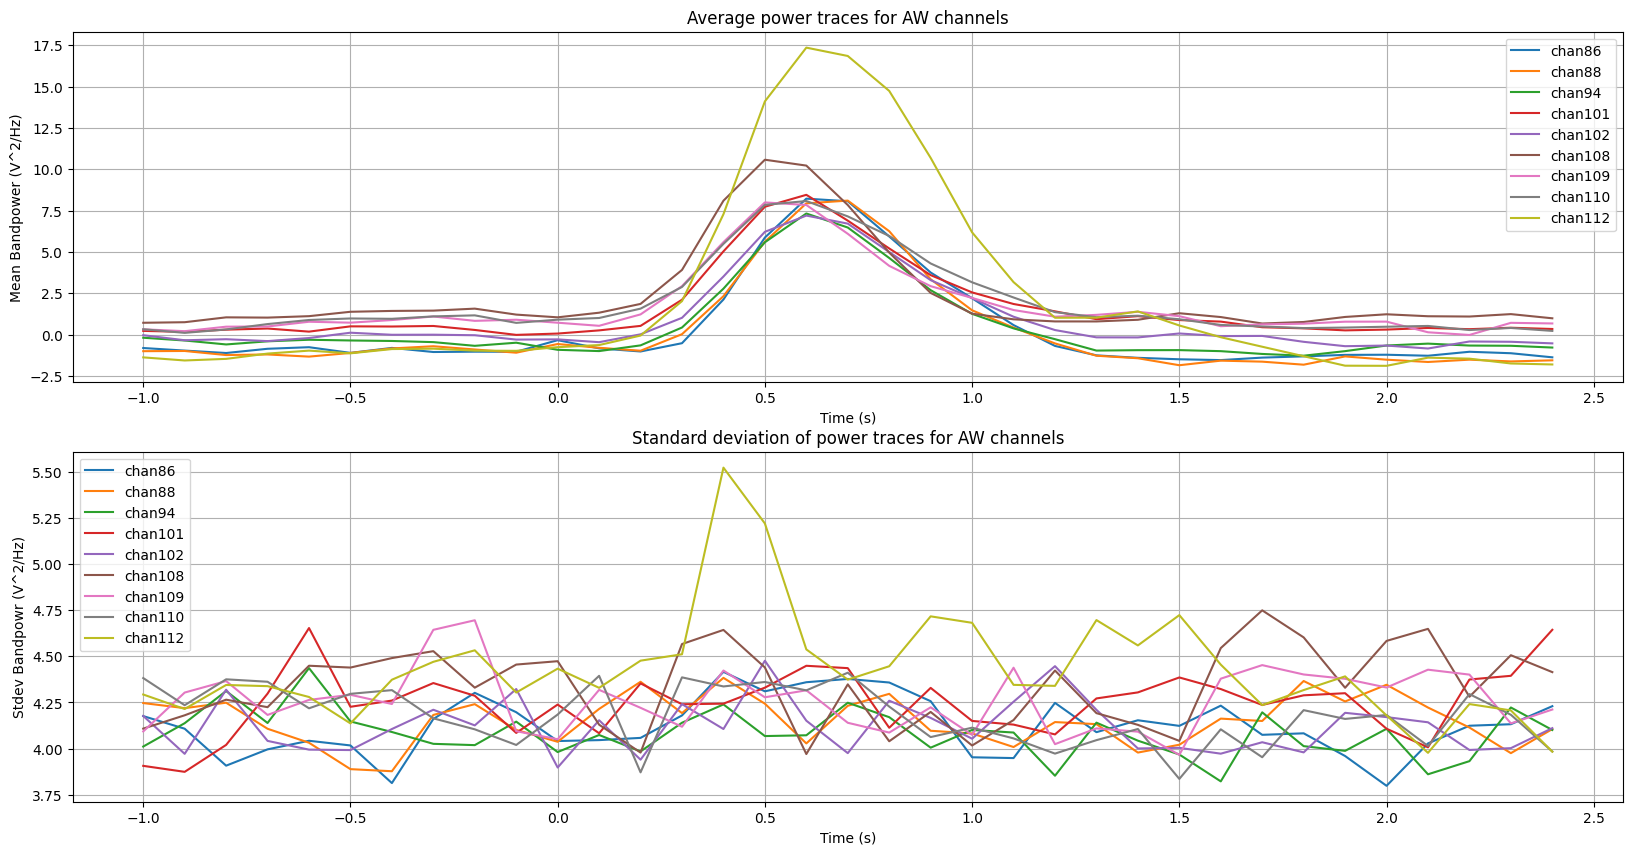

In [30]:
"""
DESCRIPTION:
The average aligned high gamma activity (across trials) is plotted for each of the channels used for affine warping. 

INPUT VARIABLES:
chs_alignment:          [list > strings]; The list of channels which will be used for affine warp. Leave as [] if
                        all channels will be used.
powerband_id:           [string]; The powerband whose average trials traces will be plotted.
ptr_aligned_all_trials: [xarray (trials x channels x powerbands x time samples) > floats (units: V^2/Hz)]; The spectral
                        information for each aligned trial (across all tasks). Time dimension is in units of seconds.
"""

# COMPUTATION:

# Visualizing the average and standard deviation of power traces.
functions_model_training_visual_labeling.visualizing_warping_channels_traces(chs_alignment, powerband_id,\
                                                                             ptr_aligned_all_trials)


# LABELING EACH TIME SAMPLE

In [45]:
"""
DESCRIPTION:
For each task, each time sample is labeled as grasp or rest according to the experimenter-specivied trial onset and offset 
and the per-trial shift.
"""

# EXPERIMENTER INPUTS:
t_grasp_start_per_trial = 0.3 #0.3 #-0.2 #0.3# -0.7 # -0.8 # 0.3 # -0.8 -0.4
t_grasp_end_per_trial   = 1.1 #1.1 # 0.8  # 0.1 # 0.1 # 1.1 # 0.2  0.3

"""
INPUT VARIABLES:
aw_shifts:               [dictionary (Key: string (Task ID); Value: dictionary (Key/Value pairs below)];
    N (where N is an int): [int]; AW shift for the Nth trial in units of samples.
grasp_bandpower_dict:    [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:           [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                         the band power is computed for each channel across every time point.
    sxx_power_z:         [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                         calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:          [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                         to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    power_trials_z:      [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                         information for each trial. Time dimension is in units of seconds.
t_grasp_end_per_trial:   [float (units: s)]; Time of trial end relative to stimulus onset.
t_grasp_start_per_trial: [float (units: s)]; Time of trial start relative to stimulus onset.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
model_classes: [list > strings]; List of all the classes to be used in the classifier.

OUTPUT VARIABLES:
labels_dict: [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
             task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
             modulation as well as the per-trial shift from the AW model.
"""

# COMPUTATION:

# Assigning per-sample labels.
labels_dict = functions_model_training_visual_labeling.creating_labels(aw_shifts, grasp_bandpower_dict, t_grasp_end_per_trial,\
                                                                       t_grasp_start_per_trial)
    

LABELING SAMPLES FOR:  task0
LABELING SAMPLES FOR:  task1
LABELING SAMPLES FOR:  task2
LABELING SAMPLES FOR:  task3
LABELING SAMPLES FOR:  task4
LABELING SAMPLES FOR:  task5


# CREATING FEATURES ACROSS POWERBANDS AND TIME HISTORY

In [46]:
"""
DESCRIPTION:
Power features across all powerbands are concatenated in one feature dimension. For example, if a feature array has
dimensions (chs: 128, powerbands: 3, time samples: 4500), the powerband concatenation will result in an array of size:
(chs x pwrbands: 384, time samples: 4500).

Then, based on the experimenter-specified time history (t_history) and the time resolution (global variable sxx_shift),
the number of historical time points are calculated (t_history/sxx_shift). An xarray with dimensions (history, features, time)
is created, where each coordinate in the history dimension represents how much the features were shifted in time. For 
example, consider one coordinate in the feature array, and suppose a time length of 10 samples and a total time history 
of 3 samples. For this feature, the resulting xarray would look like:

historical time shifts
     n=2 shifts      [[0.000, 0.000, 0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101],
     n=1 shift        [0.000, 0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521],
     n=0 shifts       [0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521, 0.882]]
                        t=0    t=1    t=2    t=3    t=4    t=5    t=6    t=7    t=8    t=9     (time samples)   

and the resulting dimensions of this array are (history=3, features=1, time=10).
"""

# EXPERIMENTER INPUTS:
t_history = 1000

"""
INPUT VARIABLES:
grasp_bandpower_dict: [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:        [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                      the band power is computed for each channel across every time point.
    sxx_power_z:      [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                      calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:       [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                      to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    power_trials_z:   [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                      information for each trial. Time dimension is in units of seconds.
t_history:            [float (unit: ms)]; Amount of feature time history.

NECESSARY FUNCTIONS:
concatenating_historical_features
concatenating_power_bands

OUTPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history, features, time) > floats (units: V^2/Hz))]
               Array of historical time features.
"""

# COMPUTATION:

# Creating feature array with concatentated power bands and historical time shifts.
features_dict = functions_model_training_visual_labeling.creating_features(grasp_bandpower_dict, t_history)


# ADJUSTING FEATURES AND LABELS TIME DIMENSION 

In [47]:
"""
DESCRIPTION:
Adjusting the time dimension of the labels and features. Due to the time history, the time-shifted rows of the features
arrays are zero padded. As such, all columns with leading zeros should be removed. If there are N time shfited columns,
this means that N-1 columns should be removed. For example, consider N = 3:

Features array:

historical time shifts
    n=2 shifts      [[0.000, 0.000, 0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101],
    n=1 shift        [0.000, 0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521],
    n=0 shifts       [0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521, 0.882]]
                        t=0    t=1    t=2    t=3    t=4    t=5    t=6    t=7    t=8    t=9     (time samples)   

    Labels:             l0     l1     l2     l3     l4     l5     l6     l7     l8     l9

After curtailing, the features and labels arrays would look like:

historical time shifts
    n=2 shifts      [[0.234, 0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101],
    n=1 shift        [0.523. 0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521],
    n=0 shifts       [0.435, 0.982, 0.175, 0.759, 0.341, 0.101, 0.521, 0.882]]
                        t=2    t=3    t=4    t=5    t=6    t=7    t=8    t=9     (time samples)   

    Labels:             l2     l3     l4     l5     l6     l7     l8     l9

where time points and labels will then be re-adjusted.


INPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history, features, time) > floats (units: V^2/Hz))]
               Array of historical time features.
labels_dict:   [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
               task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
               modulation as well as the per-trial shift from the AW model.
t_history:     [float (unit: s)]; Amount of feature time history.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling): 
sxx_shift: [int (units: ms)]; Length of time by which sliding window (sxx_window) shifts along the time domain.

OUTPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
               Array of historical time features. Number of time samples corresponding to time history are curtailed at the
               beginning of the time array.
labels_dict:   [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in a task,
               there exists a rest or grasp label depending on the experimenter-specified onset and offset of grasp modulation
               as well as the per-trial shift from the AW model. Number of time samples corresponding to time history are
               curtailed at the beginning of the time array.
"""

# COMPUTATION:

# Adjusting the features and labels time dimensions to account for zero-padded features due to the historical features array. 
features_dict,\
labels_dict = functions_model_training_visual_labeling.time_history_sample_adjustment(features_dict, labels_dict, t_history)


# EQUALIZING THE NUMBER OF SAMPLES FOR EACH CLASS

In [48]:
"""
DESCRIPTION:
According to the label array, it is unlikely that there are an equal number of samples per class. For whichever
class there are more samples, the indices of this class will be extracted to create a smaller subset of 
indices in number equal to that of the underrepresented class. For example, consider the following labels array:

labels:  ['rest', 'rest', 'rest', 'rest', 'rest, 'grasp', 'grasp', 'grasp', 'rest', 'rest', 'rest', 'rest']
indices:    0       1       2       3       4       5        6        7       8       9       10      11

In the example, there are 3 samples with grasp labels, while there are 9 samples with rest labels. The indices
corresponding to the rest labels are: [0, 1, 2, 3, 4, 8, 9, 10, 11]. These indices will be randomly subsampled
such that they are equal in number to the grasp class. For example: [0, 1, 2] or [1, 4, 10] or [3, 9, 11]. As
such the downsampled labels (and corresponding features) will use the indices:

labels downsampled:  ['rest', 'grasp', 'grasp', 'grasp', 'rest', 'rest']
indices downsampled:    3        5        6        7       9       11

INPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
               Array of historical time features.
labels_dict:   [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
               task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
               modulation as well as the per-trial shift from the AW model.

OUTPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
               Array of historical time features. Time samples reduced such that there are an equal number of features per
               class.
labels_dict:   [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
               task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
               modulation as well as the per-trial shift from the AW model. Time samples reduced such that there are an equal
               number of features per class.
"""

# COMPUTATION:

# Downsampling the labels and corresponding features of the overrepresented class.
features_dict, labels_dict = functions_model_training_visual_labeling.equalizing_samples_per_class(features_dict, labels_dict)


# SPLITTING TASKS FOR TRAINING OR VALIDATION PER-FOLD

In [49]:
"""
DESCRIPTION:
Creating dictionaries of training and validation folds where the tasks are split up per-fold.

INPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
               Array of historical time features. Time samples reduced such that there are an equal number of features per
               class.

OUTPUT VARIABLES:
train_folds_tasks  [dict (key: string (fold ID); Value: list > strings (task IDs))]; List of all the training tasks
                   for each training fold.
valid_folds_tasks: [dict (key: string (fold ID); Value: list > strings (task IDs))]; List of all the validation tasks
                   for each validation fold.
"""

# COMPUTATION:

# Splitting up the tasks into training and validation tasks per-fold.
train_folds_tasks,\
valid_folds_tasks = functions_model_training_visual_labeling.training_validation_split_tasks(features_dict)


# TRAIN/VALIDATION SPLIT DATA AND LABELS

In [50]:
"""
DESCRIPTION:
Splitting the data into training and validation blocks for building the fold-models. The validation folds will be tested
on the models built on the corresponding training folds to confirm that the decoder is generalizable to unseen data. 

INPUT VARIABLES:
features_dict:     [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
                   Array of historical time features. Time samples reduced such that there are an equal number of features per
                   class.
labels_dict:       [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
                   task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
                   modulation as well as the per-trial shift from the AW model. Time samples reduced such that there are an equal
                   number of features per class.
train_folds_tasks  [dict (key: string (fold ID); Value: list > strings (task IDs))]; List of all the training tasks
                   for each training fold.
valid_folds_tasks: [dict (key: string (fold ID); Value: list > strings (task IDs))]; List of all the validation tasks
                   for each validation fold.

OUTPUT VARIABLES:
train_data_folds:   [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                    For each training fold, feature xarrays are concatenated in the sample dimension.
train_labels_folds: [dict (key: string (fold ID); Value: xarray (1 x time samples) > strings ('grasp'/'rest'))]; For each training
                    fold, label xarrays are concatenated in the sample dimension.
valid_data_folds:   [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                    For each validation fold, feature xarrays are concatenated in the sample dimension.
valid_labels_folds: [dict (key: string (fold ID); Value: xarray (1 x time samples) > strings ('grasp'/'rest'))]; For each validation
                    fold, label xarrays are concatenated in the sample dimension.
"""

# COMPUTATION:

# Splitting the training and validation data for multiple folds. 
train_data_folds,\
train_labels_folds,\
valid_data_folds,\
valid_labels_folds = functions_model_training_visual_labeling.training_validation_split(features_dict, labels_dict,\
                                                                                        train_folds_tasks, valid_folds_tasks)

# MEAN CENTERING THE DATA ACCORDING TO THE TRAINING FOLDS

In [51]:
"""
DESCRIPTION:
Computing the mean of the data in each training fold in the time dimension. Note that only the mean of the first historical time
point is computed with the intent of only computing the PCs from the features from the first historical time point. This mean 
will be repeated in an array for as many historical time features that there are. Also note that the data in a specific training
and validation fold pair is mean-centered to the data in that specific traininig fold. 

INPUT VARIABLES:
train_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  For each training fold, feature xarrays are concatenated in the sample dimension.
valid_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  For each validation fold, feature xarrays are concatenated in the sample dimension.

OUTPUT VARIABLES:
train_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  For each training fold, feature xarrays are centered according to the corresponding training fold mean.
valid_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  For each validation fold, feature xarrays are centered according to the corresponding training fold mean.
"""

# COMPUTATION:
        
# Computing the means of the training folds.
train_data_fold_means = functions_model_training_visual_labeling.mean_compute_all_folds(train_data_folds)

# Centering the training and validation data folds according to the training data means.
train_data_folds = functions_model_training_visual_labeling.mean_centering_all_folds(train_data_folds, train_data_fold_means)
valid_data_folds = functions_model_training_visual_labeling.mean_centering_all_folds(valid_data_folds, train_data_fold_means)


# REDUCE DATA DIMENSIONALITY WITH PCA

In [52]:
"""
DESCRIPTION: 
Transforming the training and validation data into PC space for each fold. The eigenvectors for the PC transformation
are computed from the 0th point in time history. For example consider an array of dimensions (h x f x t) where h, f
and t correspond to the historical time sequence, number of features and number of time samples, respectively. 
Using a historical time features of the last 1 second with 100 ms shifts, this means that h can be any integer from
0 to 9. The PCs are computed from the 0th time history coordinate of the data array: (0 x f x t). This can be 
dimensionally reduced to an array of dimensions (f x t). The resulting PCs of dimensions (p x t) where p <= f are
applied to the (f x t) array at each historical time point. 

The number of eigenvectors are selected based on one of two experimenter-specified criteria:

1) Only keep the first eiggenvectors that that in total explain less than or equal variance to percent_var_thr
   ... or ... 
2) Only keep the first n_pc_thr eigenvectors.


INPUT VARIABLES:                        
train_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  The training data across all training tasks for each fold. 
valid_data_folds: [dict (key: string (fold ID); Value: xarray (time history x features x time samples) > floats (units: V^2/Hz))];
                  The validation data across all training tasks for each fold. 

GLOBAL PARAMETERS:
n_pc_thr:        [int]; The number of principal components to which the user wishes to reduce the data set. Set to 'None' if
                 percent_var_thr is not 'None', or set to 'None' along with percent_var_thr if all of the variance will be used
                 (no PC transform).
percent_var_thr: [float]; The percent variance which the user wishes to capture with the principal components. Will compute the
                 number of principal components which capture this explained variance as close as possible, but will not surpass
                 it. Set to 'None' if n_pc_thr is not 'None', or set to 'None' along with n_pc_thr if all of the variance will be
                 used (no PC transform).

NECESSARY FUNCTIONS:
computing_eigenvectors
pc_transform

OUTPUT VARIABLES: 
train_data_folds  [dict (Key: string (fold ID); Value: xarray (history x pc features x time samples) > floats (units: PC units)];
                  Reduced dimensionality version of the training data arrays.
valid_data_folds: [dict (Key: string (fold ID); Value: xarray (history x pc features x time samples) > floats (units: PC units)];
                  Reduced dimensionality version of the validation data arrays.
"""

# COMPUTATION:

# Computing the PC features of the training and validation data according to the eigenvectors of the training data.
train_data_folds,\
valid_data_folds = functions_model_training_visual_labeling.pc_transform_all_folds(train_data_folds, valid_data_folds)



NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100


# REARRANGING FEATURES BASED ON MODEL CHOICE

In [53]:
"""
DESCRIPTION:
Depending on the experimenter-specified model type the features array will be rearranged corresponding to the
dimensions required for model.fit() 

INPUT VARIABLES:
train_data_folds  [dict (Key: string (fold ID); Value: xarray (history x pc features x time samples) > floats (units: PC units)];
                  Reduced dimensionality version of the training data arrays.
valid_data_folds: [dict (Key: string (fold ID); Value: xarray (history x pc features x time samples) > floats (units: PC units)];
                  Reduced dimensionality version of the validation data arrays.

NECESSARY FUNCTIONS:
rearranging_features
    
OUTPUT VARIABLES:
train_data_folds: [dictionary (key: string (fold ID): Value xarray (dimensions vary based on model type) > floats)];
                  Rearranged training features. 
valid_data_folds: [dictionary (key: string (fold ID): Value xarray (dimensions vary based on model type) > floats)];
                  Rearranged validation features. 
"""

# COMPUTATION:

# Rearranging the training and validation data according to the type of model that will be fit.
train_data_folds = functions_model_training_visual_labeling.rearranging_features_all_folds(train_data_folds)
valid_data_folds = functions_model_training_visual_labeling.rearranging_features_all_folds(valid_data_folds)


# TRAINING FOLD MODELS

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_7 (Flatten)         (None, 250)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                2510      
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
154/154 [=========================

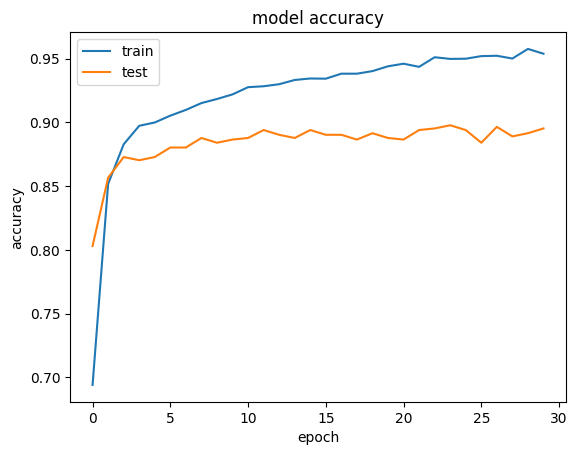

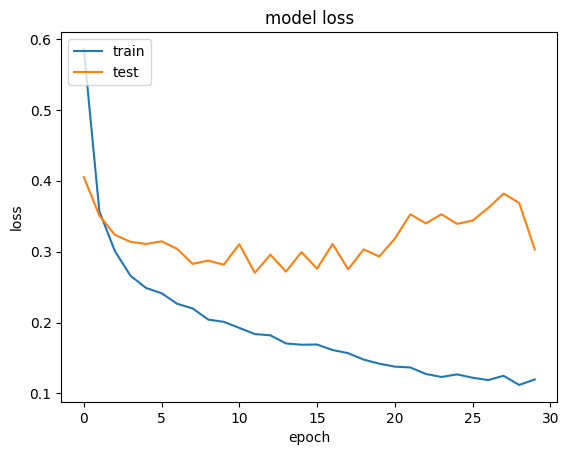

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_8 (Flatten)         (None, 250)               0         
                                                                 
 dense_16 (Dense)            (None, 10)                2510      
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
153/153 [=========================

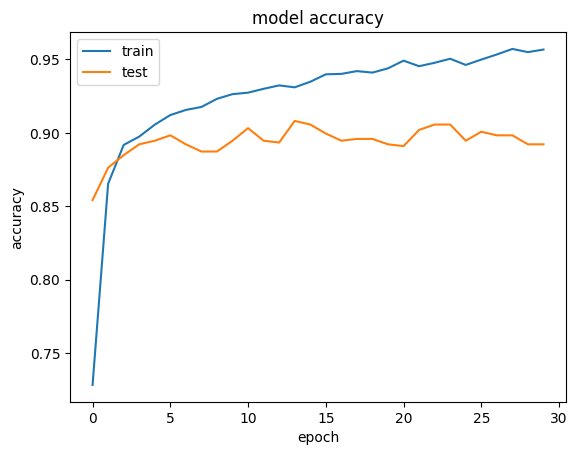

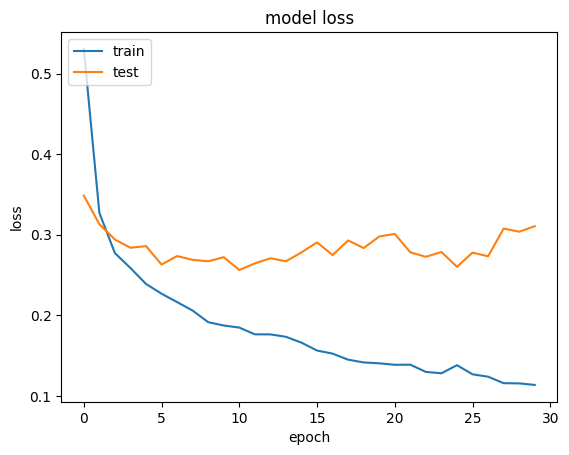

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_9 (Flatten)         (None, 250)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                2510      
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_19 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
154/154 [=========================

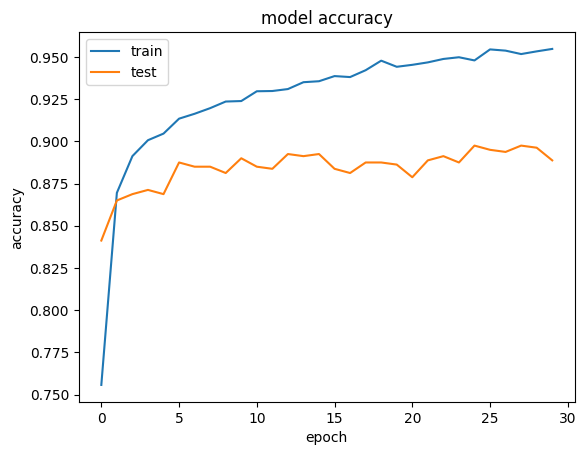

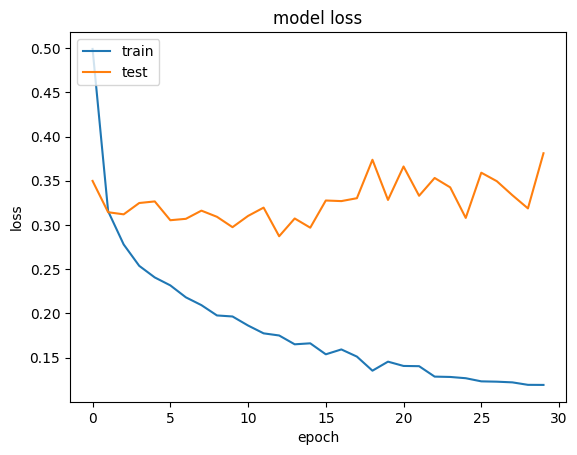

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_10 (Flatten)        (None, 250)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                2510      
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
118/118 [========================

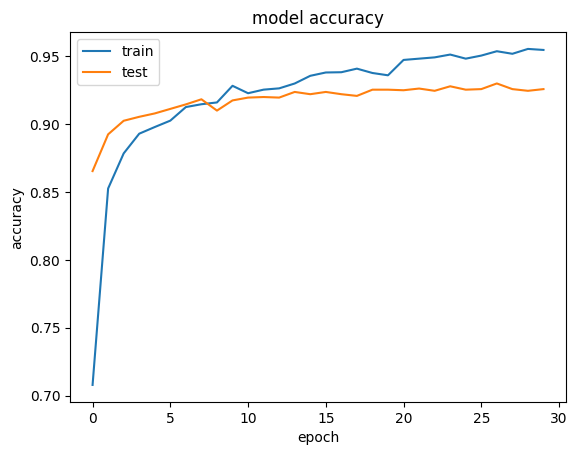

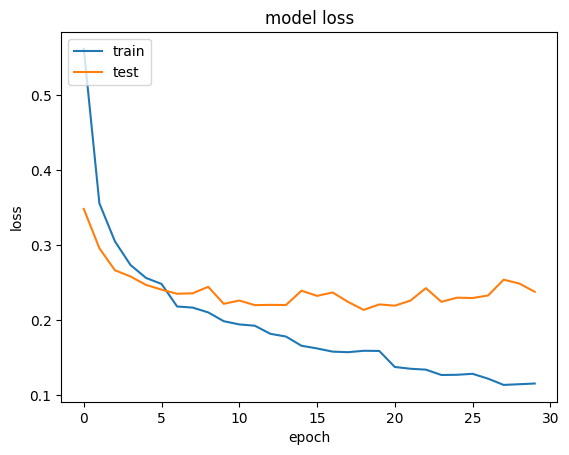

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_11 (Flatten)        (None, 250)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                2510      
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_23 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
140/140 [========================

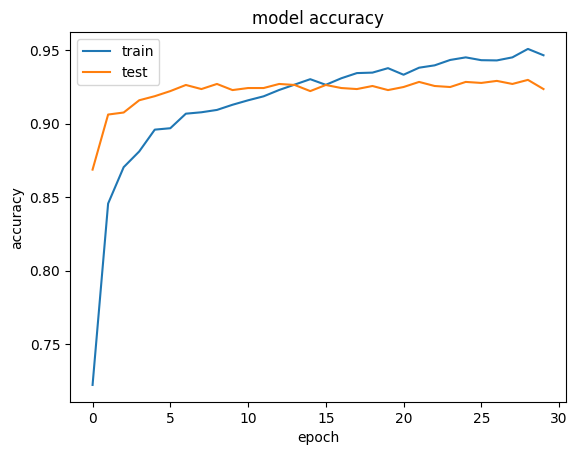

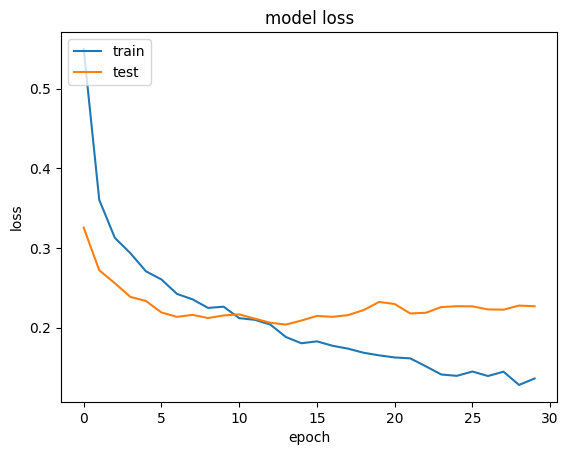

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_12 (Flatten)        (None, 250)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                2510      
                                                                 
 dropout_12 (Dropout)        (None, 10)                0         
                                                                 
 dense_25 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
140/140 [========================

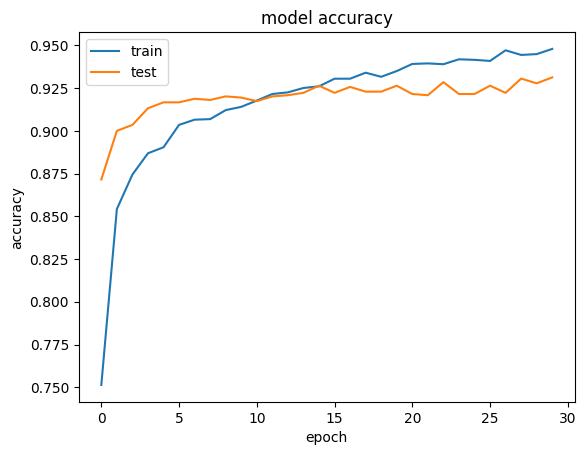

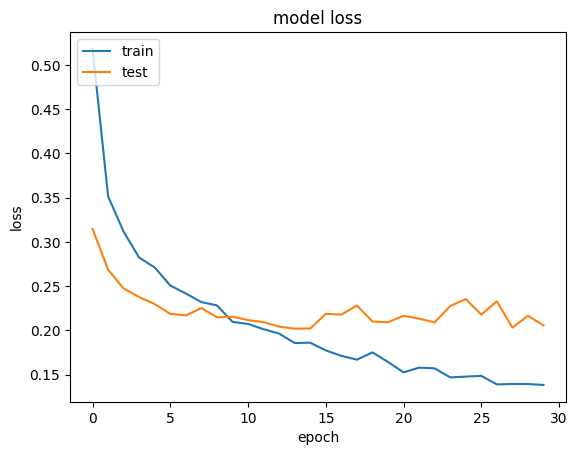

In [54]:
"""
DESCRIPTION:
This is only to be used to create a confusion matrix across all validation data folds using models trained on the 
correpsonding training data folds. Used to assess classification performance before training a final model on all
the data.

INPUT VARIABLES:
train_data_folds:   [dict (key: string (fold ID); Value: xarray (dimensions vary based on model type) > floats (units: V^2/Hz))];
                    Data across all training tasks per fold. Equal number of samples per class. PC features. Rearranged 
                    according to the type of model that will be trained.
train_labels_folds: [dict (key: string (fold ID); Value: xarray (1 x time samples) > strings ('grasp'/'rest'))]; Labels across
                    all training tasks per fold. Equal number of labels per class.
valid_data_folds:   [dict (key: string (fold ID); Value: xarray (dimensions vary based on model type) > floats (units: V^2/Hz))];
                    Data across all validation tasks per fold. Equal number of samples per class. PC features. Rearranged 
                    according to the type of model that will be trained.
valid_labels_folds: [dict (key: string (fold ID); Value: xarray (1 x time samples) > strings ('grasp'/'rest'))]; Labels across
                    all validation tasks per fold. Equal number of labels per class.
                    
GLOBAL PARAMETERS (in functions_model_training_visual_labeling):
model_type: [string ('SVM','LSTM')]; The model type that will be used to fit the data.
                         
OUTPUT VARIABLES:
fold_models: [dictionary (key: string (fold ID); Value: model)]; Models trained for each training fold.
"""
# COMPUTATION:

# Creating a model for each training fold.
fold_models = functions_model_training_visual_labeling.training_fold_models(train_data_folds, train_labels_folds,\
                                                                            valid_data_folds, valid_labels_folds)


# EVALUATING MODEL ACCURACY

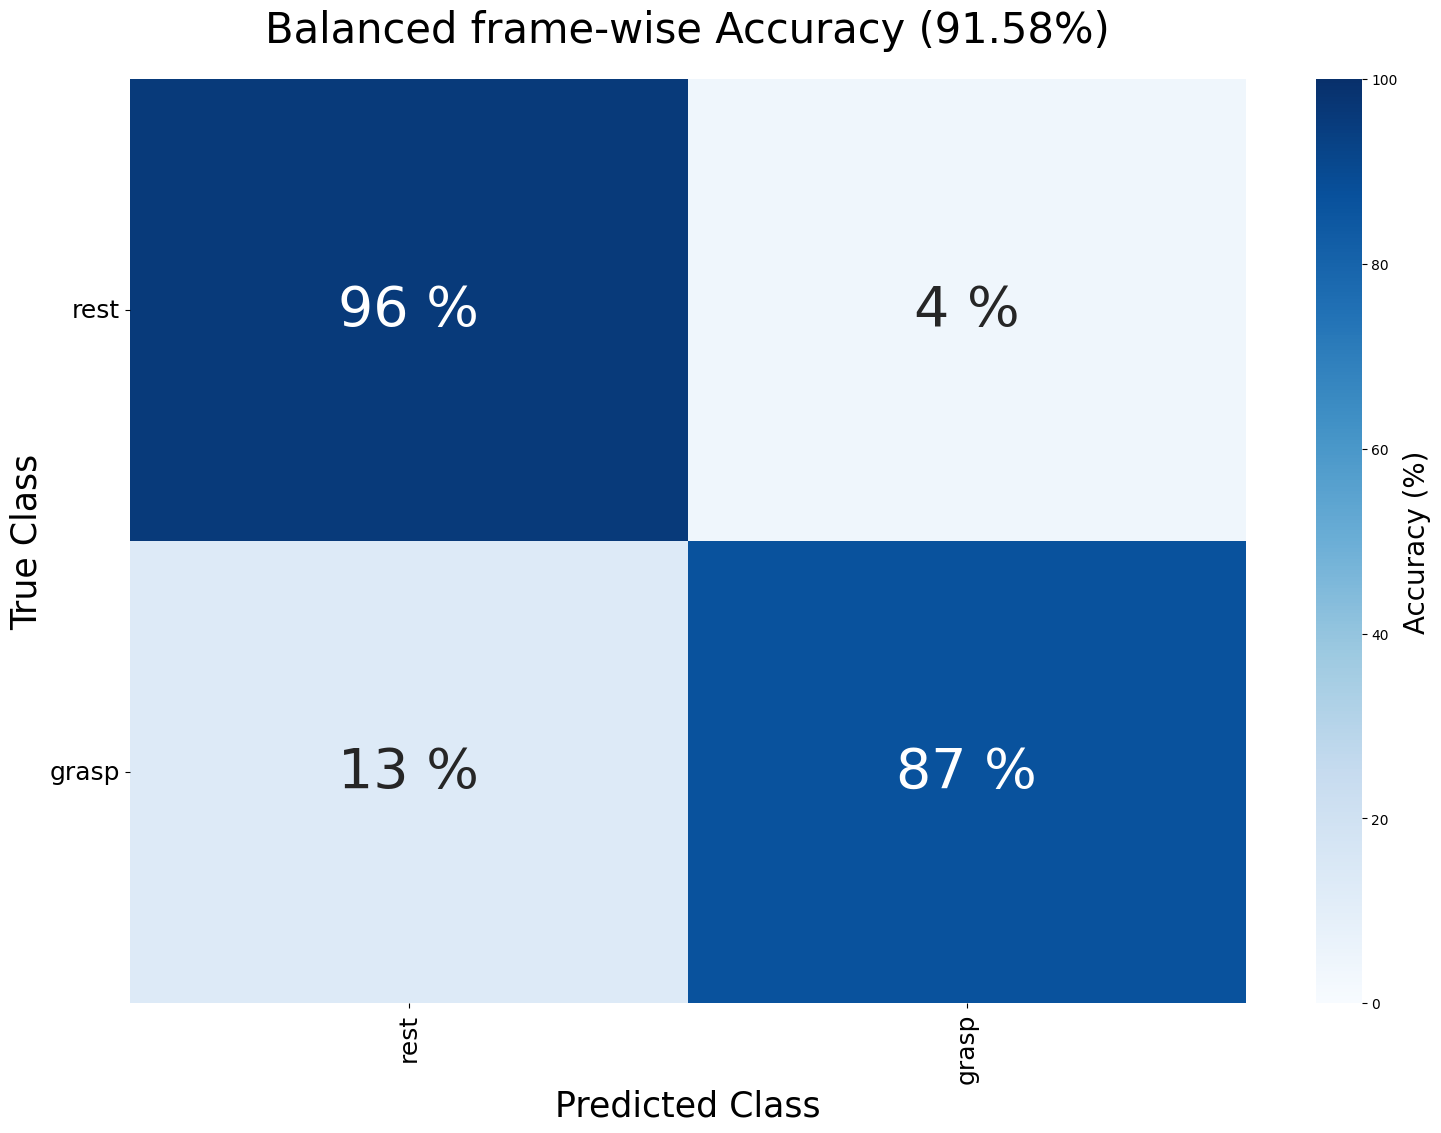

In [55]:
"""
DESCRIPTION:
Evaluating model accuracy by computing and displaying the confusion matrix of all predicted vs. true labels from
all folds.

INPUT VARIABLES:
fold_models:        [dictionary (key: string (fold ID); Value: model)]; Models trained for each training fold.
valid_data_folds:   [dict (key: string (fold ID); Value: xarray (dimensions vary based on model type) > floats (units: V^2/Hz))];
                    Data across all validation tasks per fold. Equal number of samples per class. PC features. Rearranged 
                    according to the type of model that will be trained.
valid_labels_folds: [dict (key: string (fold ID); Value: xarray (1 x time samples) > strings ('grasp'/'rest'))]; Labels across
                    all validation tasks per fold. Equal number of labels per class.

GLOBAL PARAMETERS (in functions_model_training_visual_labeling.py):
model_classes:  [list > strings]; List of all the classes to be used in the classifier.

NECESSARY FUNCTIONS:
computing_predicted_labels
confusion_matrix_display
"""

# COMPUTATION:

# Computing and displaying the confusion matrix.
functions_model_training_visual_labeling.evaluating_model_accuracy(fold_models, valid_data_folds, valid_labels_folds)


# CHANNEL IMPORTANCE

LABELING SAMPLES FOR:  task0
LABELING SAMPLES FOR:  task1
LABELING SAMPLES FOR:  task2
LABELING SAMPLES FOR:  task3
LABELING SAMPLES FOR:  task4
LABELING SAMPLES FOR:  task5

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100

NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_6 (Flatten)         (None, 250)               0         
                                                

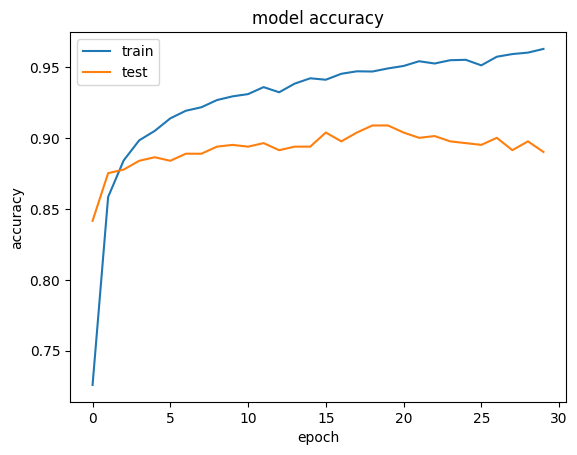

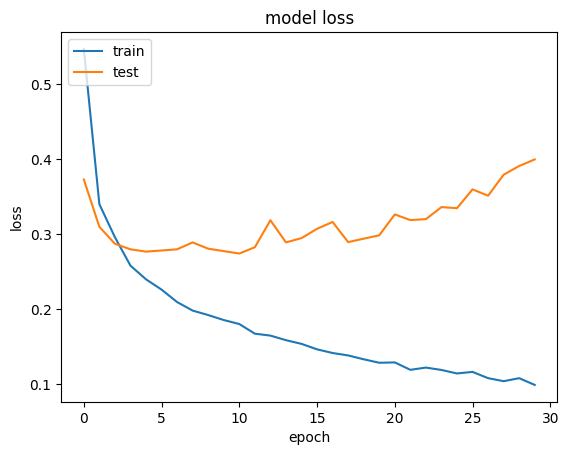

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_7 (Flatten)         (None, 250)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                2510      
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
153/153 [=========================

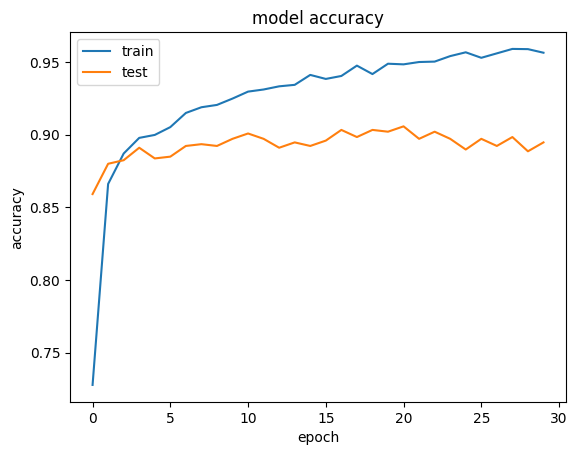

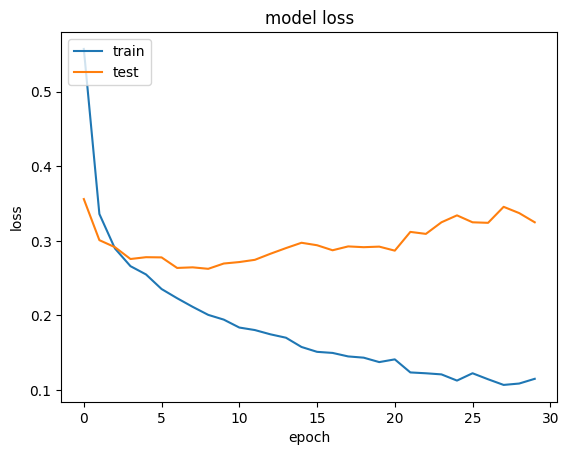

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_8 (Flatten)         (None, 250)               0         
                                                                 
 dense_16 (Dense)            (None, 10)                2510      
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
154/154 [=========================

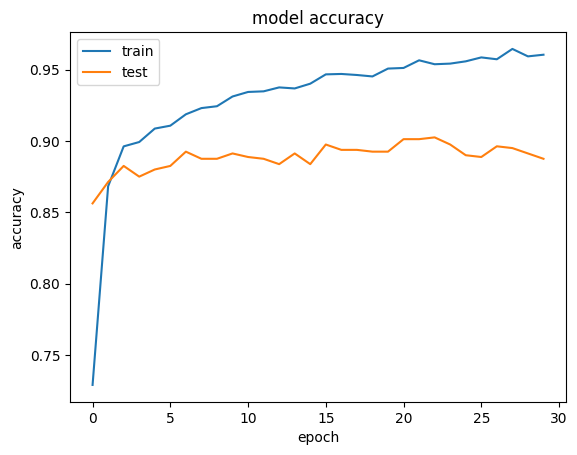

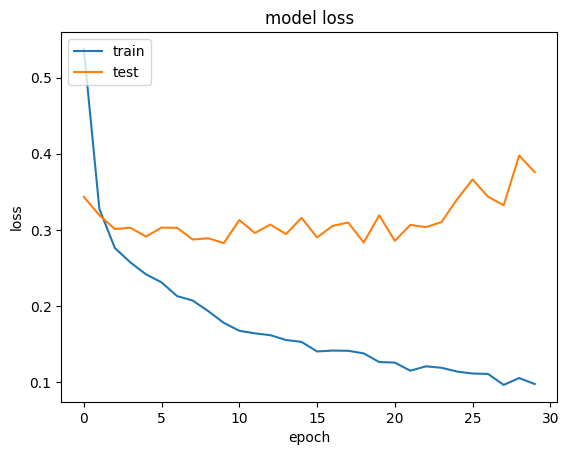

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 25)            15400     
                                                                 
 flatten_9 (Flatten)         (None, 250)               0         
                                                                 
 dense_18 (Dense)            (None, 10)                2510      
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_19 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
118/118 [=========================

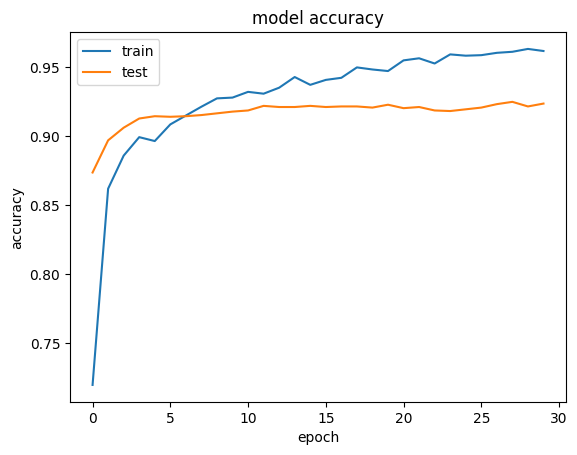

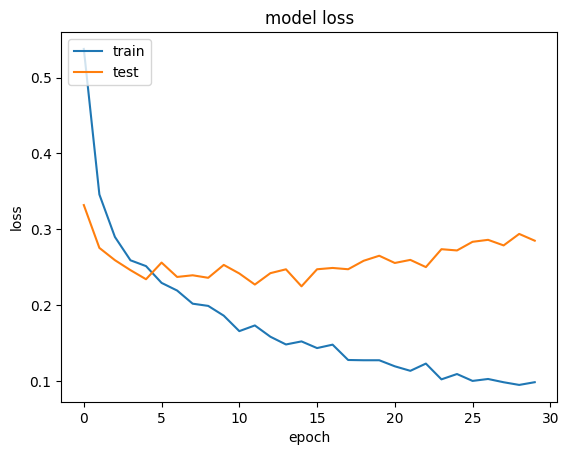

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_10 (Flatten)        (None, 250)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                2510      
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_21 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
140/140 [========================

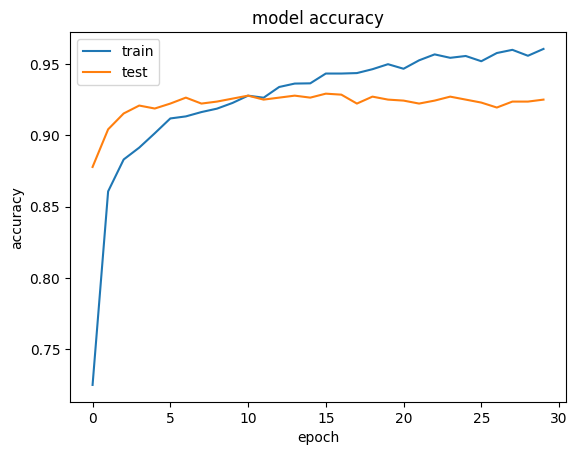

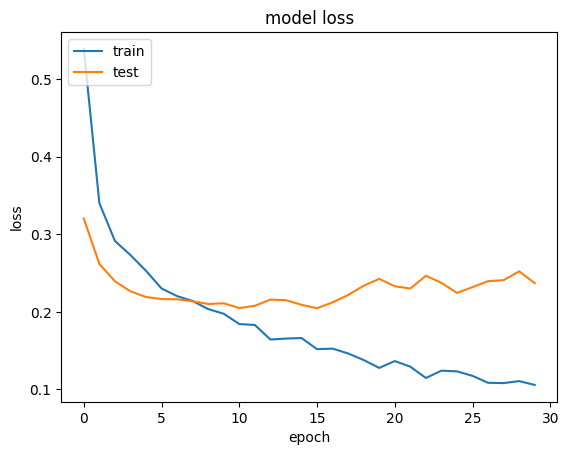

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_11 (Flatten)        (None, 250)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                2510      
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_23 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
140/140 [========================

In [ ]:
"""
DESCRIPTION:
Computing the channel importance (saliency map) to a specific class (attemped movement) in a specified frequency 
powerband. Since the saliency map is made from historical time features, for each channel, the L2 norm is taken.
These channel importances are computed for each time sample corresponding to the specific class and then the 
average is taken across all samples.
"""

# EXPERIMENTER INPUTS:
saliency_class     = 'grasp'
saliency_powerband = 'powerband0'

"""
INPUT VARIABLES:
aw_shifts:                 [dictionary (Key: string (Task ID); Value: dictionary (Key/Value pairs below)];
    N (where N is an int): [int]; AW shift for the Nth trial in units of samples.
chs_include:               [list > strings]; The list of channels to be included in further analysis.
grasp_bandpower_dict:      [dictionary (Key: string (task ID); Value: dictionary (Key/Value pairs below)];
    sxx_power:             [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each frequency band,
                           the band power is computed for each channel across every time point.
    sxx_power_z:           [xarray (channel x powerband x time samples] > floats (units: V^2/Hz)]; For each standardized (to
                           calibration) frequency band, the band power is computed for each channel across every time point.
    sxx_states:            [xarray (1 x time samples) > strings ('state_ON'/'state_OFF'/'neutral')]; Stimulus array downsampled
                           to match time resolution of the signal spectral power. Time dimension is in units of seconds.
    power_trials_z:        [xarray (trials x channels x frequency bins x time samples) > floats (units: V^2/Hz)]; The spectral
                           information for each trial. Time dimension is in units of seconds.

saliency_class:            [string]; The class for whose channel importance scores will be computed.
saliency_powerband:        [string (powerbandX)]; The powerband for whose channel importances will be computed.
t_grasp_end_per_trial:     [float (units: s)]; Time of trial end relative to stimulus onset.
t_grasp_start_per_trial:   [float (units: s)]; Time of trial start relative to stimulus onset.
t_history:                 [float (unit: ms)]; Amount of feature time history.

NECESSARY FUNCTIONS:
averaging_channel_importance_scores
computing_channel_importance_per_sample

OUTPUT VARIABLES:
ch_importance_scores: [array (1 x channels) > floats]; Mean importance score for each channel, averaged across all
                      time samples from all validation folds.
"""

# Computing the channel importance scores for the specific class and powerband.
ch_importance_scores = functions_model_training_visual_labeling.computing_channel_importance(aw_shifts, chs_include, grasp_bandpower_dict,\
                                                                                             saliency_class, saliency_powerband,  t_history,\
                                                                                             t_grasp_end_per_trial, t_grasp_start_per_trial)

# PLOTTING CHANNEL IMPORTANCE SCORES

chan97 : 0.11404
chan45 : 0.11526
chan49 : 0.11733
chan30 : 0.11793
chan34 : 0.11824
chan18 : 0.11892
chan22 : 0.11927
chan11 : 0.12022
chan42 : 0.12121
chan27 : 0.12196
chan41 : 0.12236
chan71 : 0.12441
chan61 : 0.12457
chan26 : 0.12528
chan14 : 0.12603
chan47 : 0.12625
chan66 : 0.1283
chan70 : 0.12891
chan39 : 0.13102
chan105 : 0.13137
chan20 : 0.13172
chan62 : 0.13186
chan15 : 0.13341
chan37 : 0.13353
chan19 : 0.13374
chan124 : 0.13375
chan57 : 0.13413
chan56 : 0.13455
chan32 : 0.13577
chan50 : 0.13662
chan4 : 0.13722
chan33 : 0.13735
chan64 : 0.13802
chan17 : 0.1386
chan21 : 0.13882
chan1 : 0.13972
chan54 : 0.13996
chan29 : 0.141
chan73 : 0.14107
chan3 : 0.14125
chan58 : 0.14197
chan113 : 0.14232
chan69 : 0.14252
chan52 : 0.14281
chan23 : 0.14348
chan44 : 0.14434
chan121 : 0.14438
chan9 : 0.14479
chan25 : 0.14607
chan114 : 0.14666
chan72 : 0.14681
chan31 : 0.14688
chan46 : 0.14912
chan2 : 0.14951
chan98 : 0.14995
chan5 : 0.15002
chan10 : 0.15012
chan63 : 0.15117
chan40 : 0.15194
ch

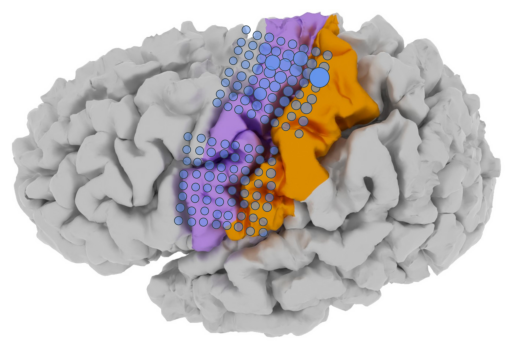

In [45]:
"""
DESCRIPTION:
Mapping the channel importance scores at the coordinates of each electrode on an image of the research participant's.
brain. Size and opaqueness of the markers on the image are proportional to that channel's importance in the neural
network for classifying the experimenter-specified class. Channel importance scores are normalized between 0 and 1.
The brain image and channel mapping information are found in the following directory:

'/mnt/shared/ecog/CC01/meta/BrainClickSaliencyMapInfo/'

Feel free to change this directory as needed.
"""
# EXPERIMENTER INPUTS:
marker_color = [100, 149, 237] # Cornflower blue. Used for all channels.
# marker_color = [72, 209, 204] # Medium turquoise. Used for all channels except for 112.
# marker_color = [240, 128, 128] # Light Coral. Used for only Hand knob channels.

"""
INPUT VARIABLES:
ch_importance_scores: [array (1 x channels) > floats]; Mean importance score for each channel, averaged across all
                      time samples from all validation folds.
chs_exclude:          [list > strings]; The list of channels to be excluded in further analysis.
chs_include:          [list > strings]; The list of channels to be included in further analysis.
marker_color:         [list > ints (R, G, B)]; Marker color represented by RBG components. Each integer value ranges 
                      from 0 to 255.
"""

# COMPUTATION:

# Plotting the channel contributions.
functions_model_training_visual_labeling.plotting_channel_contributions(ch_importance_scores, chs_exclude, chs_include, marker_color)


# TRAINING FINAL MODEL


NUMBER OF PRINCIPAL COMPONENTS:  []

PERCENT VARIANCE EXPLAINED:  100
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 25)            15400     
                                                                 
 flatten_13 (Flatten)        (None, 250)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                2510      
                                                                 
 dropout_13 (Dropout)        (None, 10)                0         
                                                                 
 dense_27 (Dense)            (None, 2)                 22        
                                                                 
Total params: 17,932
Trainable params: 17,932
Non-trainable params: 0
____________________________________________

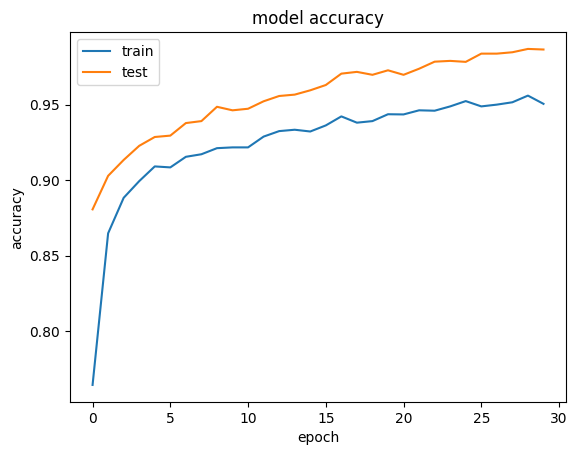

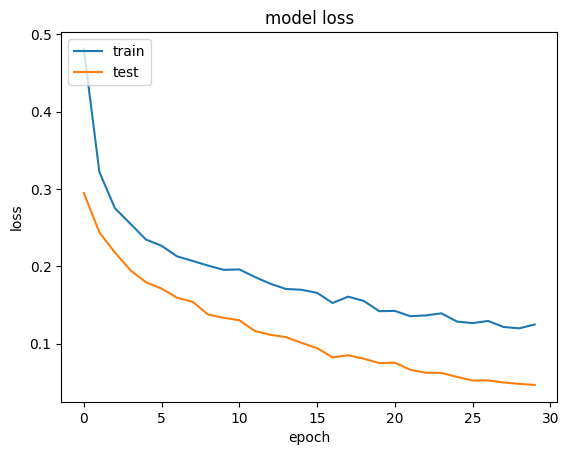

In [56]:
"""
DESCRIPTION:
Concatenating the data and labels from all tasks and training the final model on these concatenated arrays.

INPUT VARIABLES:
features_dict: [dictionary (Key: string (task ID); Value: xarray (time history x features x time) > floats (units: V^2/Hz))]
               Array of historical time features. Time samples reduced such that there are an equal number of features per
               class.
labels_dict:   [dictionary (Key: string (task ID); Value: xarray > strings ('grasp'/'rest'))]; For each time sample in each
               task, there exists a rest or grasp label depending on the experimenter-specified onset and offset of
               modulation as well as the per-trial shift from the AW model. Time samples reduced such that there are an equal
               number of features per class.
                   
NECESSARY FUNCTIONS:
computing_eigenvectors
concatenating_all_data_and_labels
mean_centering
mean_compute
model_training_lstm
pc_transform
rearranging_features
    
OUTPUT VARIABLES:
eigenvectors_final: [array (features x pc features) > floats]; Array in which columns consist of eigenvectors which explain
                    the variance of the data in descending order. 
final_model:        [classification model]; Model trained with data from all tasks.
training_data_mean: [xarray (history x features) > floats (units: V^2/Hz)]; Mean power of each feature of only the 0th time 
                    shift.  This array is repeated for each historical time point.
"""

# COMPUTATION:

# Training the final model.
eigenvectors_final,\
final_model,\
training_data_means = functions_model_training_visual_labeling.training_final_model(features_dict, labels_dict)


# SAVING PARAMETERS

In [57]:
"""
DESCRIPTION:
Saving all parameters related to the model in the experimenter-specified directory.
"""

# EXPERIMENTER INPUTS:
dir_model_info = '/mnt/shared/danprocessing/Projects/PseudoOnlineTests_for_RTCoG/ClickModels/'
model_name     = params_model_training_visual_labeling.model_name

"""
INPUT VARIABLES:
dir_model_info: [string]; Directory where the model and all relevant parameters will be saved.
model_name:     [string]; Name of the model under which all the parameters are saved.
"""


######################## BUFFER INFO #######################
# Making the buffer and packet size the same as the spectral window and shift respectively.
buffer_size = params_model_training_visual_labeling.sxx_window
packet_size = params_model_training_visual_labeling.sxx_shift

# Creating the dictionary of command information to be saved and corresponding filename.
dict_buffer     = {'buffer_size': buffer_size, 'packet_size': packet_size}
filename_buffer = 'Buffer_Info'
############################################################



######################### CAR INFO #########################
# Extracting the CAR information.
car_bool   = params_model_training_visual_labeling.car
patient_id = params_model_training_visual_labeling.patient_id
car_chs    = params_model_training_visual_labeling.car_channels[patient_id] 

# Creating the dictionary for whether or not to perform CAR filtering and the lists of channels on which to 
# perform CAR and the corresponding filename.
dict_car     = {'car': car_bool, 'car_chs': car_chs}
filename_car = 'CAR_Info'
############################################################



####################### CHANNEL INFO #######################
# Creating the dictionary of channel information to be saved and corresponding filename.
dict_channels     = {'channels_all': eeglabels, 'channels_exclude': chs_exclude, 'channels_include': chs_include}
filename_channels = 'Channel_Info'
############################################################



######################## MODEL INFO ########################
# Extracting the model classes and model type.
model_classes = params_model_training_visual_labeling.model_classes
model_type    = params_model_training_visual_labeling.model_type

# Creating the dictionary of supplemental model information.
dict_model_supplemental = {'model_classes': model_classes, 'model_type': model_type}
filename_model          = 'Model_Info'
############################################################



################## PC TRANSFORMATION INFO ##################
# Creating the dictionary of all information necessary for dimensionality reduction via PCA.
dict_pctransform     = {'eigenvectors': eigenvectors_final ,'training_data_mean': training_data_means}
filename_pctransform = 'PC_Info'
############################################################



################### SPECTRAL INFORMATION ###################
f_power_max   = params_model_training_visual_labeling.f_power_max
f_power_min   = params_model_training_visual_labeling.f_power_min
sampling_rate = params_model_training_visual_labeling.sampling_rate
sxx_shift     = params_model_training_visual_labeling.sxx_shift
sxx_window    = params_model_training_visual_labeling.sxx_window

# Creating the dictionary of spectral information and the corresponding filename.
dict_sxx     = {'f_max_bounds': f_power_max, 'f_min_bounds': f_power_min, 'sampling_rate': sampling_rate, 'sxx_shift': sxx_shift, 'sxx_window': sxx_window}
filename_sxx = 'SXX_Info'
############################################################



################# TIME HISTORY INFORMATION #################
# Creating the dictionary of relevant time history information and the corresponding filename.
dict_time_history = {'t_history': t_history}
filename_time_history = 'History_Info'
############################################################


# SAVING

# Computing the directory for the final model.
dir_model = dir_model_info + model_name + '/'

# Saving all parameters.
functions_model_training_visual_labeling.save_info(dict_buffer, dir_model, filename_buffer)
functions_model_training_visual_labeling.save_info(dict_car, dir_model, filename_car)
functions_model_training_visual_labeling.save_info(dict_channels, dir_model, filename_channels)
functions_model_training_visual_labeling.save_info(dict_time_history, dir_model, filename_time_history)
functions_model_training_visual_labeling.save_info(dict_model_supplemental, dir_model, filename_model)
functions_model_training_visual_labeling.save_info(dict_pctransform, dir_model, filename_pctransform)
functions_model_training_visual_labeling.save_info(dict_sxx, dir_model, filename_sxx)

# Saving the model.
functions_model_training_visual_labeling.save_model(final_model, dir_model, filename_model)


INFO:tensorflow:Assets written to: /mnt/shared/danprocessing/Projects/PseudoOnlineTests_for_RTCoG/ClickModels/TestModel/Model_Info/Model/assets


INFO:tensorflow:Assets written to: /mnt/shared/danprocessing/Projects/PseudoOnlineTests_for_RTCoG/ClickModels/TestModel/Model_Info/Model/assets


In [58]:
model_name

'TestModel'